In [40]:
spark.stop()

In [1]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
#if DEVEL_SRC not in sys.path:
#    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    

import time
start_time = time.time()

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline  
EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
if EXTERNAL_LIB not in sys.path:
    sys.path.append(EXTERNAL_LIB)
# feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
# the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
%load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:120% !important; }</style>"))

<IPython.core.display.Javascript object>

# Spark session

In [2]:
import time
start_time = time.time()

from churn_nrt.src.utils.spark_session import get_spark_session

sc, spark, sql_context = get_spark_session("nb_virgin")
sc.setLogLevel('WARN')

# Imports

In [3]:
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf,countDistinct, \
        desc, asc, to_date, create_map, sum as sql_sum, substring, sort_array, split, month, dayofmonth, avg as sql_avg
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType, DateType, FloatType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain
import argparse

import csv
import re
import subprocess
import sys
import time
from pyspark.sql import SparkSession, SQLContext
import itertools
from pyspark.sql.functions import concat_ws, date_format, from_unixtime, \
    length, lit, lower, lpad, month, regexp_replace, translate, udf, unix_timestamp, year, when, upper
from pyspark.sql.utils import AnalysisException
from collections import Counter
from pyspark.sql.types import StringType
#from churn.analysis.ccc_churn.engine.data_loader import get_port, get_ccc_data, get_tgs, get_all_ports
#from churn.datapreparation.general.data_loader import get_active_services
#from churn.analysis.ccc_churn.engine.reporter import compute_results, SAVING_PATH, init_writer, print_sheet
#from churn.analysis.ccc_churn.app.run_ccc_churn_analysis import join_dfs

In [25]:
from churn_nrt.src.data.navcomp_data import NavCompAdvData


#df_metadata = NavCompAdvData(spark).get_metadata()
#cols_metadata = df_metadata.rdd.map(lambda x: x['feature']).collect()

df_navcomp = NavCompAdvData(spark).get_module("20200610")
#set(cols_metadata) ^ set(df_navcomp.columns)
from churn_nrt.src.utils.pyspark_utils import count_nans_beta
A = count_nans_beta(df_navcomp)
A

[DataTemplate] __init__ | module name = navcomp_adv | path = /data/udf/vf_es/churn_nrt/navcomp_adv | verbose = True
[DataTemplate] get_module | module navcomp_adv - for closing_day=20200610 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp_adv/year=2020/month=6/day=10'


{}

In [7]:

cols_to_module = [col_ for col_ in df_navcomp_all.columns if col_ == "msisdn" or col_.endswith("_d7") or col_.endswith("_d15") or col_.endswith("_d30") or col_.endswith("_d60") or col_.startswith("inc_")]


set(df_navcomp_all.columns) & set(cols_to_module)



{'inc_JAZZTEL_distinct_days_with_navigation_d15',
 'inc_JAZZTEL_distinct_days_with_navigation_d30',
 'inc_JAZZTEL_distinct_days_with_navigation_d7',
 'inc_JAZZTEL_max_count_d15',
 'inc_JAZZTEL_max_count_d30',
 'inc_JAZZTEL_max_count_d7',
 'inc_JAZZTEL_max_days_since_navigation_d15',
 'inc_JAZZTEL_max_days_since_navigation_d30',
 'inc_JAZZTEL_max_days_since_navigation_d7',
 'inc_JAZZTEL_min_days_since_navigation_d15',
 'inc_JAZZTEL_min_days_since_navigation_d30',
 'inc_JAZZTEL_min_days_since_navigation_d7',
 'inc_JAZZTEL_sum_count_d15',
 'inc_JAZZTEL_sum_count_d30',
 'inc_JAZZTEL_sum_count_d7',
 'inc_LOWI_distinct_days_with_navigation_d15',
 'inc_LOWI_distinct_days_with_navigation_d30',
 'inc_LOWI_distinct_days_with_navigation_d7',
 'inc_LOWI_max_count_d15',
 'inc_LOWI_max_count_d30',
 'inc_LOWI_max_count_d7',
 'inc_LOWI_max_days_since_navigation_d15',
 'inc_LOWI_max_days_since_navigation_d30',
 'inc_LOWI_max_days_since_navigation_d7',
 'inc_LOWI_min_days_since_navigation_d15',
 'inc_LO

In [11]:
df_mob.select("target_operator").distinct().show()

+---------------+
|target_operator|
+---------------+
|         orange|
|       masmovil|
|      euskaltel|
|       movistar|
|         others|
+---------------+



In [7]:

def add_postal_code(df, closing_day):

    if not "num_cliente" in df.columns:

        from churn_nrt.src.data.customer_base import CustomerBase
        df_base = CustomerBase(spark).get_module(closing_day).drop_duplicates(["msisdn"]).where(col("rgu")=="mobile")
        
    
        UNKNOWN_TAG = "unknown"

        from churn_nrt.src.data.customers_data import Customer
        df_cust = Customer(spark).get_module(closing_day, add_columns=["codigo_postal"])
        df_cust = df_cust.withColumn("cp", col("codigo_postal").substr(0, 2))
        df_cust = df_cust.withColumn("cp",  when(col("cp").rlike("^\d{2}$"), col("cp")).otherwise(UNKNOWN_TAG))
        
    
    print("CHECK-postal-1")
    print([col_ for col_ in df.columns if "num_cliente" in col_])
    print("CHECK-postal-2")
    print([col_ for col_ in df_base.columns if "num_cliente" in col_])
    
    df_join1 =  df.join(df_base.select("msisdn", "num_cliente"), on=["msisdn"], how="left")
    
    print("CHECK-postal-3")
    print([col_ for col_ in df_join1.columns if "num_cliente" in col_])

    df_join = df_join1.join(df_cust.select("num_cliente", "cp"), on=["num_cliente"], how="left")
    print("CHECK-postal-4")
    print([col_ for col_ in df_join.columns if "num_cliente" in col_])
    
    
    return df_join






In [42]:

closing_day = "20200622"

from churn_nrt.src.data.sopos_dxs import MobPort
df_mob = MobPort(spark, 14).get_module(closing_day).withColumnRenamed("label_mob", "label") 

from churn_nrt.src.data.navcomp_data import NavCompAdvData

df_navcomp_all = NavCompAdvData(spark).get_module(closing_day)


df_navcomp_all = df_navcomp_all.join(df_mob, on=["msisdn"], how="left").fillna({"label":0.0})
df_navcomp_all = df_navcomp_all.withColumn("label_virgin", when(col("target_operator")=="euskaltel", 1).otherwise(0))



#print("hola1", df_navcomp_all.count())
df_navcomp_all = add_postal_code(df_navcomp_all, closing_day)
#print("hola2", df_navcomp_all.count())

# Comunidades autonomas
ccaa = {'galicia': ['15', '27', '32', '36'],
        'asturias': ['33'],
        'cantabria': ['39'],
        'paisvasco': ['01', '20', '48'],
        'navarra': ['31'],
        'aragon': ['22', '44', '50'],
        'cataluna': ['08', '17', '25', '43'],
        'cyl': ['09', '24', '34', '05', '37', '40', '47', '42', '49'],
        'rioja': ['26'],
        'extremadura': ['06', '10'],
        'madrid': ['28'],
        'clm': ['02', '16', '19', '13', '45'],
        'valencia': ['03', '12', '46'],
        'murcia': ['30'],
        'andalucia': ['21', '14', '11', '41', '23', '18', '04', '29'],
        'baleares': ['07'],
        'canarias': ['35', '38'],
        'cym': ['51', '52'],
        'otros': ['00', 'unknown']}


df_navcomp_all = df_navcomp_all.withColumn("ccaa", when(col("cp").isin(ccaa["paisvasco"]), "paisvasco").when(col("cp").isin(ccaa["navarra"]), "navarra").when(col("cp").isin(ccaa["rioja"]), "rioja").otherwise("other"))


df_navcomp_all = df_navcomp_all.cache()

print("NAVCOMP COUNT", df_navcomp_all.count())

[DataTemplate] __init__ | module name = mob_port/14 | path = /data/udf/vf_es/churn_nrt/mob_port/14 | verbose = True
[DataTemplate] get_module | module mob_port/14 - for closing_day=20200622 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok


KeyboardInterrupt: 

In [ ]:
df_navcomp_all = df_navcomp_all.where(col("VIRGINTELCO_sum_count_last15")>0)
print("NAVCOMP COUNT", df_navcomp_all.count())

In [7]:
df_navcomp_all.where(col("VIRGINTELCO_sum_count_last7")>0).count()

3120

In [9]:


from churn_nrt.src.data.sopos_dxs import MobPort
df_mob = MobPort(spark, 14).get_module(closing_day).withColumnRenamed("label_mob", "label") 

from churn_nrt.src.data.customer_base import CustomerBase
df_base = CustomerBase(spark).get_module(closing_day).drop_duplicates(["msisdn"]).where(col("rgu")=="mobile")
df_base = df_base.join(df_mob, on=["msisdn"], how="left").fillna({"label":0.0})
df_base = df_base.withColumn("label_virgin", when(col("target_operator")=="euskaltel", 1).otherwise(0))

    

churn_rate_base = df_base.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
churn_rate_base_virgin = df_base.select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']


print("Reference churn rate = {}%".format(churn_rate_base * 100.0))
print("virgin churn rate = {}%".format(churn_rate_base_virgin * 100.0))



[DataTemplate] __init__ | module name = mob_port/14 | path = /data/udf/vf_es/churn_nrt/mob_port/14 | verbose = True
[DataTemplate] get_module | module mob_port/14 - for closing_day=20200620 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/mob_port/14/year=2020/month=6/day=20'
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200620 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=20'
Reference churn rate = 0.799042694162%
virgin churn rate = 0.04234102884

In [21]:
df_base.select("msisdn").drop_duplicates(["msisdn"]).count()

5720220

In [36]:
from churn_nrt.src.projects.models.virgin.model_classes import set_label
from churn_nrt.src.utils.date_functions import move_date_n_days

closing_day_B = move_date_n_days(closing_day, n=15)
tr_set = set_label(spark, closing_day, df_navcomp_all, 15)



Adding label with target days 15 - [20200621,20200706]
[DataTemplate] __init__ | module name = navcomp/15 | path = /data/udf/vf_es/churn_nrt/navcomp/15 | verbose = True
[DataTemplate] get_module | module navcomp/15 - for closing_day=20200706 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[NavCompData] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp/15/year=2020/month=7/day=6'
[DataTemplate] __init__ | module name = callscomp/15 | path = /data/udf/vf_es/churn_nrt/callscomp/15 | verbose = True
[DataTemplate] get_module | module callscomp/15 - for closing_day=20200706 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CallsCompData] check_valid_params | Params ok
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/callscomp/15/year=2020/month=7/day=6'. Starting generation...
[DataTemplate] __init__

[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=7/day=6'
[CallsCompData] get_metadata | Building metadata dataframe
[CallsCompData] get_metadata | Building metadata dataframe
[Metadata] apply_metadata
[Metadata] fillna | Nothing to impute with mean
[Metadata] fillna | imputing nans in 183 numeric columns
[DataTemplate] get_module | module 'callscomp/15' | Elapsed time in build_module function: 3.17241393328 minutes
[DataTemplate] get_module | module 'callscomp/15' | About to call save for path '/data/udf/vf_es/churn_nrt/callscomp/15' with args and closing_day=20200706
[DataTemplate] save | Started saving at '/data/udf/vf_es/churn_nrt/callscomp/15' partitioned by year=2020/month=7/day=6 (mode=append)
[DataTemplate] save | Saved /data/udf/vf_es/churn_nrt/callscomp/15/year=2020/month=7/day=6 [Elapsed time = 1.45819876591 minutes]


In [34]:
tr_set.drop_duplicates(["msisdn"]).where(col("label_VIRGINTELCO_sum_count_last15")>=2).count()

516

In [37]:
tr_set.drop_duplicates(["msisdn"]).where(col("label_VIRGINTELCO_sum_count_last15")>=2).count()

530

In [7]:
operator_ = "VIRGINTELCO"
from churn_nrt.src.data.customer_base import add_postal_code


#closing_day = "20200622"

for closing_day in ["20200618", "20200619", "20200620", "20200621", "20200622", "20200623"]:

    print("*******", closing_day, "*********")
    
    from churn_nrt.src.data.sopos_dxs import MobPort
    df_mob = MobPort(spark, 14).get_module(closing_day).withColumnRenamed("label_mob", "label") 

    from churn_nrt.src.data.navcomp_data import NavCompAdvData

    df_navcomp_all = NavCompAdvData(spark).get_module(closing_day)


    df_navcomp_all = df_navcomp_all.join(df_mob, on=["msisdn"], how="left").fillna({"label":0.0})
    df_navcomp_all = df_navcomp_all.withColumn("label_virgin", when(col("target_operator")=="euskaltel", 1).otherwise(0))



    #print("hola1", df_navcomp_all.count())
    df_navcomp_all = add_postal_code(spark, df_navcomp_all, closing_day)
    #print("hola2", df_navcomp_all.count())

    # Comunidades autonomas
    ccaa = {'galicia': ['15', '27', '32', '36'],
            'asturias': ['33'],
            'cantabria': ['39'],
            'paisvasco': ['01', '20', '48'],
            'navarra': ['31'],
            'aragon': ['22', '44', '50'],
            'cataluna': ['08', '17', '25', '43'],
            'cyl': ['09', '24', '34', '05', '37', '40', '47', '42', '49'],
            'rioja': ['26'],
            'extremadura': ['06', '10'],
            'madrid': ['28'],
            'clm': ['02', '16', '19', '13', '45'],
            'valencia': ['03', '12', '46'],
            'murcia': ['30'],
            'andalucia': ['21', '14', '11', '41', '23', '18', '04', '29'],
            'baleares': ['07'],
            'canarias': ['35', '38'],
            'cym': ['51', '52'],
            'otros': ['00', 'unknown']}


    df_navcomp_all = df_navcomp_all.withColumn("ccaa", when(col("cp").isin(ccaa["paisvasco"]), "paisvasco").when(col("cp").isin(ccaa["navarra"]), "navarra").when(col("cp").isin(ccaa["rioja"]), "rioja").otherwise("other"))


    df_navcomp_all = df_navcomp_all.cache()

    print("NAVCOMP COUNT", df_navcomp_all.count())


    import numpy as np
    for pp in [7, 15]:

        for var in ["{}_sum_count_last{}".format(operator_, pp), 
                   # '{}_max_count_last{}'.format(operator_,pp),
                    #'inc_{}_sum_count_d{}'.format(operator_,pp),
                    #'inc_{}_max_count_d{}'.format(operator_,pp),
                    # '{}_distinct_days_with_navigation_last{}'.format(operator_,pp),
                    #  "sum_distinct_days_with_navigation_comps_last{}".format(pp),
                    # 'inc_{}_max_days_since_navigation_d{}'.format(operator_,pp),
                    # 'inc_{}_min_days_since_navigation_d{}'.format(operator_,pp),
                    # 'inc_{}_distinct_days_with_navigation_d{}'.format(operator_,pp),
                    # '{}_max_days_since_navigation_last{}'.format(operator_,pp),
                    # '{}_min_days_since_navigation_last{}'.format(operator_,pp),
                ]:


            max_val = int(np.ceil(df_navcomp_all.where(col(var)>0).select(sql_max(var).alias(var)).rdd.first()[var]))
            #print("--- max value for column {} is {}".format(var, max_val))

            if max_val <= 10:
                sep = 1
            elif max_val <= 22:
                sep = 1
            elif max_val <= 50:
                sep = 2
            elif max_val >=1000:
                sep = 500
            else:
                sep = 1

            for lev in range(0,max_val+1,sep):

                vol = df_navcomp_all.where(col(var)>0).where(col(var)>=lev).count()

                #churn_rate = df_navcomp_all.where(col(var)>=lev).select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
                churn_rate_virgin = df_navcomp_all.where(col(var)>0).where(col(var)>=lev).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
                churn_rate_virgin_nopaisvasco = df_navcomp_all.where(col(var)>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
                churn_rate_virgin_nonorte = df_navcomp_all.where(col(var)>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']


                print("{}>={}|{}|{}|{}".format(var, 
                #print("{}>={}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}".format(var, 
                                                                  lev, 
                                                                  df_navcomp_all.where(col(var)>0).where(col(var)>=lev).count(), 
                                                                  df_navcomp_all.where(col(var)>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco"])).count(),
                                                                  df_navcomp_all.where(col(var)>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).count(),

                                                                  #100.0 * churn_rate, churn_rate / churn_rate_base,
#                                                                   100.0* churn_rate_virgin, 
#                                                                  churn_rate_virgin / churn_rate_base_virgin,
#                                                                  100.0* churn_rate_virgin_nopaisvasco, 
#                                                                  churn_rate_virgin_nopaisvasco / churn_rate_base_virgin,                                          
#                                                                  100.0* churn_rate_virgin_nonorte, 
#                                                                  churn_rate_virgin_nonorte / churn_rate_base_virgin, max_val                                                                                       
                                                                                                           ))

                if vol<1000:
                    print("exiting since volume is less than 1000..")
                    break



('*******', '20200618', '*********')
[DataTemplate] __init__ | module name = mob_port/14 | path = /data/udf/vf_es/churn_nrt/mob_port/14 | verbose = True
[DataTemplate] get_module | module mob_port/14 - for closing_day=20200618 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/mob_port/14/year=2020/month=6/day=18'
[DataTemplate] __init__ | module name = navcomp_adv | path = /data/udf/vf_es/churn_nrt/navcomp_adv | verbose = True
[DataTemplate] get_module | module navcomp_adv - for closing_day=20200618 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp_adv/year=2020/month=6/day=18'
[DataTemplate] __init__ | module name = customer | path = /data/udf/vf_es/churn_nrt/customer | verbo

[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=20'
('NAVCOMP COUNT', 1694553)
VIRGINTELCO_sum_count_last7>=0|3120|3048|2957
VIRGINTELCO_sum_count_last7>=1|3120|3048|2957
VIRGINTELCO_sum_count_last7>=2|3119|3047|2956
VIRGINTELCO_sum_count_last7>=3|1241|1210|1172
VIRGINTELCO_sum_count_last7>=4|1240|1209|1171
VIRGINTELCO_sum_count_last7>=5|505|494|481
exiting since volume is less than 1000..
VIRGINTELCO_sum_count_last15>=0|5806|5674|5509
VIRGINTELCO_sum_count_last15>=1|5806|5674|5509
VIRGINTELCO_sum_count_last15>=2|5804|5672|5507
VIRGINTELCO_sum_count_last15>=3|2284|2229|2167
VIRGINTELCO_sum_count_last15>=4|2283|2228|2166
VIRGINTELCO_sum_count_last15>=5|949|932|909
exiting since volume is less than 1000..
('*******', '20200621', '*********')
[DataTemplate] __init__ | module name = mob_port/14 | path = /data/udf/vf_es/churn_nrt/mob_port/14 | verbose = True
[DataTemplate] get_module | module mob_port/14 - for clo

[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp_adv/year=2020/month=6/day=23'
[DataTemplate] __init__ | module name = customer | path = /data/udf/vf_es/churn_nrt/customer | verbose = True
[DataTemplate] get_module | module customer - for closing_day=20200623 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_columns': ['codigo_postal']}
[Customer] is_default_module | args: () | kwargs: {'add_columns': ['codigo_postal']}
[Customer] is_default_module | Module customer cannot be saved since 'add_columns' is different than None
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/customer/year=2020/month=6/day=23'. Starting generation...
[Customer] build_module | Requested additional_columns ['codigo_postal']
[DataTemplate] get_module | module 'customer' | Elapsed time in build_module function: 0.402270750205 minutes
[DataTemplate] get_module | module 'customer' | Module wi

In [10]:
operator_ = "VIRGINTELCO"

import numpy as np
for pp in [7,15,30]:
    
    for var in ['most_consulted_operator_last{}'.format(pp)]:
            
                
        vol = df_navcomp_all.where(col(var)==pp).count()

        churn_rate_virgin = df_navcomp_all.where(col(var)==operator_).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
        churn_rate_virgin_nopaisvasco = df_navcomp_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
        churn_rate_virgin_nonorte = df_navcomp_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']



        print("{}=={}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}".format(var, 
                                                          operator_, 
                                                          df_navcomp_all.where(col(var)==operator_).count(), 
                                                          df_navcomp_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco"])).count(),
                                                          df_navcomp_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).count(),

                                                          #100.0 * churn_rate, churn_rate / churn_rate_base,
                                                          100.0* churn_rate_virgin, 
                                                         churn_rate_virgin / churn_rate_base_virgin,
                                                         100.0* churn_rate_virgin_nopaisvasco, 
                                                         churn_rate_virgin_nopaisvasco / churn_rate_base_virgin,                                          
                                                         100.0* churn_rate_virgin_nonorte, 
                                                         churn_rate_virgin_nonorte / churn_rate_base_virgin, max_val                                                                                       
                                                                                                   ))

        #if vol<2000:
        #    print("exiting since volume is less than 2000..")
        #    break


most_consulted_operator_last7==VIRGINTELCO|1863|1822|1768|4.56253354804|107.719251608|4.50054884742|106.255822245|4.41176470588|104.159670802|15
most_consulted_operator_last15==VIRGINTELCO|3078|3015|2935|3.02144249513|71.3348232782|2.98507462687|70.4761951694|2.89608177172|68.3751160971|15
most_consulted_operator_last30==VIRGINTELCO|2273|2232|2171|3.47558293005|82.0568634034|3.40501792115|80.3908570347|3.31644403501|78.2996696217|15


# Llamadas a competidores

In [90]:
df_master_comp = spark.read.load("/data/raw/vf_es/lookup/COMPETITOR_TELEPHONE/1.0/parquet")

df_master_comp = df_master_comp.withColumn("COMPETIDOR", when(col("COMPETIDOR").rlike("^MASM.VIL"), "MASMOVIL").otherwise(col("COMPETIDOR")))
df_master_comp = df_master_comp.withColumn("GROUP", when(col("GROUP").rlike("MASM.VIL"), "MASMOVIL").otherwise(col("GROUP")))


df_pandas = df_master_comp.groupby("COMPETIDOR", "GROUP").count().toPandas()

In [94]:
group2comp_dict = df_pandas.groupby(['GROUP'])["COMPETIDOR"].apply(lambda x: ','.join(x)).reset_index().set_index("GROUP").to_dict()["COMPETIDOR"]

for gr, comp in group2comp_dict.items():
    group2comp_dict[str(gr)] = str(comp).split(",")
group2comp_dict

{u'JAZZTEL': ['JAZZTEL'],
 u'MASMOVIL': ['MASMOVIL'],
 u'MOVISTAR': ['MOVISTAR'],
 u'O2': ['O2'],
 u'ORANGE': ['ORANGE'],
 u'PEPEPHONE': ['PEPEPHONE'],
 u'VIRGIN': ['VIRGIN', 'R', 'EUSKALTEL'],
 u'VIRTUALES': ['DIGLmobil',
  'DIGI',
  'LEBARA MOVIL',
  'CARREFOUR MOVIL',
  'ORTEL MOBILE',
  'LYCA MOBIL',
  'REPUBLICA MOVIL',
  'ORBITEL MOBILE',
  'GT MOBILE',
  'BLAU',
  'HAPPY MOVIL',
  'SIMYO',
  'TALKOUT',
  'AMENA'],
 u'YOIGO': ['YOIGO']}

In [18]:
closing_day = "20200620"
#WINDOW_LENGTH = 15


GROUPS = ["VIRTUALES", "MOVISTAR", "YOIGO", "MASMOVIL", "O2", "JAZZTEL", "ORANGE", "VIRGIN", "PEPEPHONE"]

COMPETITORS = ["LEBARA MOVIL", "AMENA", "MOVISTAR", "REPUBLICA MOVIL", "BLAU", "LYCA MOBIL", "ORTEL MOBILE", "SIMYO", "GT MOBILE", "YOIGO", "O2", "HAPPY MOVIL", "R", "DIGI", "MASMOVIL", 
               "CARREFOUR MOVIL", "DIGLmobil", "ORBITEL MOBILE", "EUSKALTEL", "JAZZTEL", "ORANGE", "TALKOUT", "VIRGIN",  "PEPEPHONE"]



def build_module(closing_day, WINDOW_LENGTH):

    PATH_CDR_RAW = "/data/raw/vf_es/mediated_cdr/NAVAJO/1.0/parquet/"

    level = "msisdn"

    GROUPS = ["VIRTUALES", "MOVISTAR", "YOIGO", "MASMOVIL", "O2", "JAZZTEL", "ORANGE", "VIRGIN", "PEPEPHONE"]

    COMPETITORS = ["LEBARA MOVIL", "AMENA", "MOVISTAR", "REPUBLICA MOVIL", "BLAU", "LYCA MOBIL", "ORTEL MOBILE", "SIMYO", "GT MOBILE", "YOIGO", "O2", "HAPPY MOVIL", "R", "DIGI", "MASMOVIL", 
                   "CARREFOUR MOVIL", "DIGLmobil", "ORBITEL MOBILE", "EUSKALTEL", "JAZZTEL", "ORANGE", "TALKOUT", "VIRGIN",  "PEPEPHONE"]



    from churn_nrt.src.utils.date_functions import move_date_n_days
    starting_day = move_date_n_days(closing_day, n=-abs(WINDOW_LENGTH))



    from pyspark.sql.functions import col, when, coalesce, lit, length, datediff

    from churn_nrt.src.utils.hdfs_functions import get_partitions_path_range
    cdr_paths = get_partitions_path_range(PATH_CDR_RAW, starting_day, closing_day)






    def process_one_day(spark, path_, closing_day):

        df_master_comp = spark.read.load("/data/raw/vf_es/lookup/COMPETITOR_TELEPHONE/1.0/parquet")
        df_master_comp = df_master_comp.withColumn("COMPETIDOR", when(col("COMPETIDOR").rlike("MASM.VIL"), "MASMOVIL").otherwise(col("COMPETIDOR")))
        df_master_comp = df_master_comp.withColumn("GROUP", when(col("GROUP").rlike("MASM.VIL"), "MASMOVIL").otherwise(col("GROUP")))




        df_cdr = spark.read.load(path_)
        df_cdr = df_cdr.join(df_master_comp, on=(df_master_comp["TELEPHONE_NUMBER"]==df_cdr["NRSECUN"]), how="inner").where(col("CDSENLLA")=="OL")

        from churn_nrt.src.data.customer_base import CustomerBase
        df_cb = CustomerBase(spark).get_module(closing_day)

        df_cdr = df_cdr.join(df_cb.select("msisdn"), on=(df_cdr["NRPRIMA"]==df_cb["msisdn"]), how="inner")


        df_gr = (df_cdr.groupBy("msisdn", "GROUP", "COMPETIDOR", "DTINILLA").agg(
                            sql_count("*").alias("num_calls"),
                            sql_sum("TMDURLLA").alias("sum_duration"),
                            sql_avg("TMDURLLA").alias("avg_duration"))
        .withColumn("days_since_call", datediff(from_unixtime(unix_timestamp(lit(closing_day), "yyyyMMdd")), from_unixtime(unix_timestamp(col("DTINILLA"), "yyyyMMdd"))).cast("double")))

        return df_gr



    parts_ = [process_one_day(spark, path_, closing_day) for path_ in cdr_paths]

    df_cdr_grs = reduce(lambda a, b: a.union(b), parts_)



    import itertools
    from functools import partial
    from pyspark.sql.functions import (greatest, least)

    count_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["num_calls"]))]
    distinct_days_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["distinct_days_with_calls"]))]
    min_days_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["min_days_since_call"]))]
    max_days_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["max_days_since_call"]))]


    count_feats_gr= [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["num_calls_group"]))]
    distinct_days_feats_gr = [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["distinct_days_with_calls_group"]))]
    min_days_feats_gr = [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["min_days_since_call_group"]))]
    max_days_feats_gr = [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["max_days_since_call_group"]))]



    df_cdr_grs_comp = (df_cdr_grs.groupBy(level).pivot("COMPETIDOR", COMPETITORS).agg(sql_count("*").alias("num_calls"), 
                                                                                         sql_max("num_calls").alias("max_calls_day"),
                                                                                         sql_max("days_since_call").alias("max_days_since_call"),
                                                                                         sql_min("days_since_call").alias("min_days_since_call"),
                                                                                         countDistinct("DTINILLA").alias("distinct_days_with_calls")))
    df_cdr_grs_groups = (df_cdr_grs.groupBy(level).pivot("GROUP", GROUPS).agg(sql_count("*").alias("num_calls_group"), 
                                                                                         sql_max("num_calls").alias("max_calls_day_group"),
                                                                                         sql_max("days_since_call").alias("max_days_since_call_group"),
                                                                                         sql_min("days_since_call").alias("min_days_since_call_group"),
                                                                                         countDistinct("DTINILLA").alias("distinct_days_with_calls_group")))




    def get_most_consulted_operator(ops_list, consulted_list, days_since_1st_navigation_list):
        if not consulted_list: return "None"
        combined_list = [(a, b, c) for a, b, c in zip(consulted_list, days_since_1st_navigation_list, ops_list)]
        # sort by consulted list and then by days since 1st navigation
        sorted_list = sorted(combined_list, key=lambda x: (x[0], x[1]), reverse=True)
        return sorted_list[0][2] if sorted_list else "None"

    get_most_consulted_comp_udf = udf(partial(get_most_consulted_operator, COMPETITORS), StringType())
    get_most_consulted_group_udf = udf(partial(get_most_consulted_operator, GROUPS), StringType())


    df_cdr_all = (df_cdr_grs_comp.join(df_cdr_grs_groups.drop("num_cliente"), on=["msisdn"], how="outer")
                      .withColumn("num_distinct_groups", reduce(lambda a, b: a + b, [when(col(x) > 0, 1.0).otherwise(0.0) for x in count_feats_gr ]))
                      .withColumn("num_distinct_comps", reduce(lambda a, b: a + b, [when(col(x) > 0, 1.0).otherwise(0.0) for x in count_feats_comp ]))

                      .withColumn("max_count_comps", greatest(*[x for x in count_feats_comp]))
                      .withColumn("max_count_group", greatest(*[x for x in count_feats_gr]))

                      .withColumn("min_count_comps", least(*[x for x in count_feats_comp]))
                      .withColumn("min_count_group", least(*[x for x in count_feats_gr]))


                       .withColumn("sum_distinct_days_with_calls", reduce(lambda a, b: a + b, [col(x) for x in distinct_days_feats_comp]))                                               
                      .withColumn("norm_sum_distinct_days_with_calls", col("sum_distinct_days_with_calls").cast('double') / lit(WINDOW_LENGTH).cast('double'))


                      .withColumn('days_since_1st_call_comp_list', array(*[col_ + "_max_days_since_call" for col_ in COMPETITORS]))
                      .withColumn('days_since_1st_call_group_list', array(*[col_ + "_max_days_since_call_group" for col_ in GROUPS]))

                       .withColumn('comp_called_list', array(*count_feats_comp))
                       .withColumn('group_called_list', array(*count_feats_gr))


                      .withColumn('most_consulted_comp', get_most_consulted_comp_udf(col("comp_called_list"), col("days_since_1st_call_comp_list")))#.drop('consulted_list', 'days_since_1st_navigation_list'))
                      .withColumn('most_consulted_group', get_most_consulted_group_udf(col('group_called_list'), col("days_since_1st_call_group_list")))#.drop('consulted_list', 'days_since_1st_navigation_list'))



                      .withColumn("min_days_since_call_group", least(*[x for x in min_days_feats_gr]))
                      .withColumn("norm_min_days_since_call_group",  col("min_days_since_call_group").cast('double') / lit(WINDOW_LENGTH).cast('double'))

                      .withColumn("max_days_since_call_group", least(*[x for x in max_days_feats_gr]))
                      .withColumn("norm_max_days_since_call_group",  col("max_days_since_call_group").cast('double') / lit(WINDOW_LENGTH).cast('double'))


                      .withColumn("min_days_since_call_comps", least(*[x for x in min_days_feats_comp]))
                      .withColumn("norm_min_days_since_call_comps",  col("min_days_since_call_comps").cast('double') / lit(WINDOW_LENGTH).cast('double'))

                      .withColumn("max_days_since_call_comps", least(*[x for x in max_days_feats_comp]))
                      .withColumn("norm_max_days_since_call_comps",  col("max_days_since_call_comps").cast('double') / lit(WINDOW_LENGTH).cast('double'))


                           ).drop('comp_called_list', 'group_called_list',  'days_since_1st_call_comp_list', 'days_since_1st_call_group_list')


    print("CHECK2")
    print([col_ for col_ in df_cdr_all.columns if "num_cliente" in col_])
    
    df_cdr_all = apply_metadata(get_metadata(), df_cdr_all)
    
#     from churn_nrt.src.data.sopos_dxs import MobPort
#     df_mob = MobPort(spark, 14).get_module(closing_day).withColumnRenamed("label_mob", "label") 


    df_cdr_all = add_postal_code(df_cdr_all, closing_day)
    # Comunidades autonomas
    ccaa = {'galicia': ['15', '27', '32', '36'],
            'asturias': ['33'],
            'cantabria': ['39'],
            'paisvasco': ['01', '20', '48'],
            'navarra': ['31'],
            'aragon': ['22', '44', '50'],
            'cataluna': ['08', '17', '25', '43'],
            'cyl': ['09', '24', '34', '05', '37', '40', '47', '42', '49'],
            'rioja': ['26'],
            'extremadura': ['06', '10'],
            'madrid': ['28'],
            'clm': ['02', '16', '19', '13', '45'],
            'valencia': ['03', '12', '46'],
            'murcia': ['30'],
            'andalucia': ['21', '14', '11', '41', '23', '18', '04', '29'],
            'baleares': ['07'],
            'canarias': ['35', '38'],
            'cym': ['51', '52'],
            'otros': ['00', 'unknown']}


    print("CHECK3")
    print([col_ for col_ in df_cdr_all.columns if "num_cliente" in col_])
    
    df_cdr_all = df_cdr_all.withColumn("ccaa", when(col("cp").isin(ccaa["paisvasco"]), "paisvasco").when(col("cp").isin(ccaa["navarra"]), "navarra").when(col("cp").isin(ccaa["rioja"]), "rioja").otherwise("other"))



    
    return df_cdr_all.drop("num_cliente")



In [19]:
#METADATA


def get_metadata():


    print("[NavCompData] get_metadata | Building metadata dataframe")


    import itertools
    from functools import partial
    from pyspark.sql.functions import (greatest, least)

    count_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["num_calls"]))]
    distinct_days_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["distinct_days_with_calls"]))]
    min_days_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["min_days_since_call"]))]
    max_days_feats_comp = [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["max_days_since_call"]))]


    count_feats_gr= [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["num_calls_group"]))]
    distinct_days_feats_gr = [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["distinct_days_with_calls_group"]))]
    min_days_feats_gr = [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["min_days_since_call_group"]))]
    max_days_feats_gr = [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["max_days_since_call_group"]))]
    
    
    add_feats = []



    zero_add_feats = ["num_distinct_groups", "num_distinct_comps", "max_count_comps", "max_count_group", "min_count_comps", "min_count_group", "sum_distinct_days_with_calls", "norm_sum_distinct_days_with_calls",
                  "max_days_since_call_group", "norm_max_days_since_call_group",
                       "max_days_since_call_comps", "norm_max_days_since_call_comps"] +\
    [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["num_calls_group", "max_calls_day_group",  "max_days_since_call_group", "distinct_days_with_calls_group"]))] +\
    [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["num_calls", "max_calls_day",  "max_days_since_call", "distinct_days_with_calls"]))]


    th_feats = ["min_days_since_call_comps", "norm_min_days_since_call_comps", "min_days_since_call_group", "norm_min_days_since_call_group"] +\
    [p[0] + "_" + p[1] for p in list(itertools.product(GROUPS, ["min_days_since_call_group"]))] +\
    [p[0] + "_" + p[1] for p in list(itertools.product(COMPETITORS, ["min_days_since_call"]))]


    null_imp_dict = dict(
        [(x, 0) for x in count_feats_comp+count_feats_gr] + [(x, 0) for x in distinct_days_feats_comp+distinct_days_feats_gr] + [(x, 10000) for x in max_days_feats_comp+max_days_feats_gr] + 
        [(x, 0) for x in zero_add_feats] + [(x, 10000) for x in th_feats])


    feats = null_imp_dict.keys()

    na_vals = [str(x) for x in null_imp_dict.values()]

    # TODO add in production most_consulted operator
    cat_feats = ["most_consulted_comp", "most_consulted_group"]
    cat_na_vals = ["None", "None"]

    data = {'feature': feats+cat_feats, 'imp_value': na_vals+cat_na_vals}

    import pandas as pd

    metadata_df = spark.createDataFrame(pd.DataFrame(data)) \
        .withColumn('source', lit('navcomp')) \
        .withColumn('type', lit('numeric')) \
        .withColumn('type', when(col('feature').isin(cat_feats), 'categorical').otherwise(col('type'))) \
        .withColumn('level', lit('nif'))

    return metadata_df


In [20]:
def apply_metadata(metadata_df, df_cdr_all):

    metadata_map = metadata_df.where( ((col("imp_value") != "KK") & (col("type") != "array"))).select("feature", "imp_value", "type").rdd.map(lambda x: (x["feature"], x["imp_value"], x["type"])).collect()
    print("[Metadata] fillna | imputing nans in {} numeric columns".format(len(metadata_map)))

    metadata_map = dict([(x[0], str(x[1])) if x[2] == "categorical" else  (x[0], float(x[1])) for x in metadata_map])


    df_cdr_all = df_cdr_all.na.fill(metadata_map)
    
    return df_cdr_all

In [97]:
del df_cdr_all_last7


In [21]:
WINDOW_LENGTH = 7
df_cdr = build_module(closing_day, WINDOW_LENGTH)
new_suffixed_cols = [col_ + "_last"+str(WINDOW_LENGTH) if col_ not in ["msisdn", "num_cliente"] else col_ for col_ in df_cdr.columns]
df_cdr_all_7 = df_cdr.toDF(*new_suffixed_cols)


WINDOW_LENGTH = 15
df_cdr = build_module(closing_day, WINDOW_LENGTH)
new_suffixed_cols = [col_ + "_last"+str(WINDOW_LENGTH) if col_ not in ["msisdn", "num_cliente"] else col_ for col_ in df_cdr.columns]
df_cdr_all_15 = df_cdr.toDF(*new_suffixed_cols)



df_cdr_all = df_cdr_all_15.join(df_cdr_all_7.drop("num_cliente"), on=["msisdn"], how="outer")



df_cdr_all = df_cdr_all.join(df_mob, on=["msisdn"], how="left").fillna({"label":0.0})
df_cdr_all = df_cdr_all.withColumn("label_virgin", when(col("target_operator")=="euskaltel", 1).otherwise(0))






[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200620 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=20'
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200620 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=20'
[DataTemplate] __init__ | module name = customer

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200620 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=20'
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200620 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=20'
[DataTemplate] __init__ | module name = customer

In [32]:
[col_ for col_ in df_calls.columns if "LEBARA" in col_]

['LEBARA_MOVIL_num_calls',
 'LEBARA_MOVIL_max_calls_day',
 'LEBARA_MOVIL_max_days_since_call',
 'LEBARA_MOVIL_min_days_since_call',
 'LEBARA_MOVIL_distinct_days_with_calls']

In [ ]:
from churn_nrt.src.data.calls_comps_data import CallsCompData
closing_day = "20200620"
df_calls = CallsCompData(spark, 7).get_module(closing_day, save=False)

df_calls.where(col("VIRGIN_num_calls")>0).count()

In [12]:
cols_sources = df_calls.columns


cols_metadata = CallsCompData(spark, 7).get_metadata().rdd.map(lambda x: x['feature']).collect()


set(cols_sources) ^ set(cols_metadata)


[DataTemplate] __init__ | module name = callscomp/7 | path = /data/udf/vf_es/churn_nrt/callscomp/7 | verbose = True
[CallsCompData] get_metadata | Building metadata dataframe


{'msisdn'}

In [ ]:
from churn_nrt.src.data.calls_comps_data import CallsCompData, CallsCompAdvData


df_callsadv = CallsCompAdvData(spark).get_module(closing_day)

cols_sources = df_callsadv.columns


cols_metadata = CallsCompAdvData(spark).get_metadata().rdd.map(lambda x: x['feature']).collect()


set(cols_sources) ^ set(cols_metadata)

In [ ]:
from churn_nrt.src.data.customer_base

In [22]:

df_cdr_all = df_cdr_all.cache()
print("hola3", df_cdr_all.count())


metadata_df = get_metadata()


dfs_metadata = []
for dd in [7,15]:
    metadata_df_ = metadata_df.withColumn("feature", when(col("feature").isin("msisdn", "nif_cliente", "num_cliente"), col("feature")).otherwise(concat(col("feature"), lit("_last{}".format(dd)))))
    dfs_metadata.append(metadata_df_)

    
from churn_nrt.src.utils.pyspark_utils import union_all

metadata_df = union_all(dfs_metadata)
metadata_df = metadata_df.drop_duplicates(["feature"])
    
metadata_map = metadata_df.where( ((col("imp_value") != "KK") & (col("type") != "array"))).select("feature", "imp_value", "type").rdd.map(lambda x: (x["feature"], x["imp_value"], x["type"])).collect()

metadata_map = dict([(x[0], str(x[1])) if x[2] == "categorical" else  (x[0], float(x[1])) for x in metadata_map])


df_cdr_all = df_cdr_all.na.fill(metadata_map)


from churn_nrt.src.utils.pyspark_utils import count_nans_beta

A = count_nans_beta(df_cdr_all)
A

('hola3', 93442)
[NavCompData] get_metadata | Building metadata dataframe


{'ccaa_last7': 1,
 'cp_last15': 1,
 'cp_last7': 1,
 'portout_date_mob': 1,
 'target_operator': 1}

In [23]:
# churn_rate_base = df_cdr_all.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
# churn_rate_base_virgin = df_cdr_all.select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']


print("Reference churn rate = {}%".format(churn_rate_base * 100.0))
print("virgin churn rate = {}%".format(churn_rate_base_virgin * 100.0))



Reference churn rate = 0.800145159929%
virgin churn rate = 0.0423557932079%


In [24]:
df_cdr_all = df_cdr_all.where(col("VIRGIN_num_calls_last15")>0)
print("llamantes", df_cdr_all.count())


('llamantes', 812)


In [75]:
df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).count()

426

In [26]:
df_cdr_all = df_cdr_all.withColumn("ccaa", col("ccaa_last15"))


# Comunidades autonomas
ccaa = {'galicia': ['15', '27', '32', '36'],
        'asturias': ['33'],
        'cantabria': ['39'],
        'paisvasco': ['01', '20', '48'],
        'navarra': ['31'],
        'aragon': ['22', '44', '50'],
        'cataluna': ['08', '17', '25', '43'],
        'cyl': ['09', '24', '34', '05', '37', '40', '47', '42', '49'],
        'rioja': ['26'],
        'extremadura': ['06', '10'],
        'madrid': ['28'],
        'clm': ['02', '16', '19', '13', '45'],
        'valencia': ['03', '12', '46'],
        'murcia': ['30'],
        'andalucia': ['21', '14', '11', '41', '23', '18', '04', '29'],
        'baleares': ['07'],
        'canarias': ['35', '38'],
        'cym': ['51', '52'],
        'otros': ['00', 'unknown']}

operator_ = "VIRGIN"
from churn_nrt.src.data.customer_base import add_postal_code

import numpy as np


import numpy as np
for pp in [7]:
    

    for var in ['{}_num_calls_last{}'.format(operator_,pp),
                '{}_max_calls_day_last{}'.format(operator_,pp),
                 '{}_max_days_since_call_last{}'.format(operator_,pp),
                # '{}_min_days_since_call_last{}'.format(operator_,pp),
                 '{}_distinct_days_with_calls_last{}'.format(operator_,pp),
                 '{}_num_calls_group_last{}'.format(operator_,pp),
                 '{}_max_calls_day_group_last{}'.format(operator_,pp),
                 '{}_max_days_since_call_group_last{}'.format(operator_,pp),
               #  '{}_min_days_since_call_group_last{}'.format(operator_,pp),
                 '{}_distinct_days_with_calls_group_last{}'.format(operator_,pp)
               ]:




        max_val = int(np.ceil(df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).select(sql_max(var).alias(var)).rdd.first()[var]))
        #print("--- max value for column {} is {}".format(var, max_val))

        if max_val <= 10:
            sep = 1
        elif max_val <= 20:
            sep = 2
        elif max_val <= 50:
            sep = 5
        elif max_val >=1000:
            sep = 500
        else:
            sep = 10

        for lev in range(0,max_val+1,sep):

            vol = df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).count()

            #churn_rate = df_navcomp_all.where(col(var)>=lev).select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
            churn_rate_virgin = df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
            churn_rate_virgin_nopaisvasco = df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
            churn_rate_virgin_nonorte = df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']



            print("{}>={}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}".format(var, 
                                                              lev, 
                                                              df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).count(), 
                                                              df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco"])).count(),
                                                              df_cdr_all.where(col("VIRGIN_num_calls_last7")>0).where(col(var)>=lev).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).count(),

                                                              #100.0 * churn_rate, churn_rate / churn_rate_base,
                                                              100.0* churn_rate_virgin, 
                                                             churn_rate_virgin / churn_rate_base_virgin,
                                                             100.0* churn_rate_virgin_nopaisvasco, 
                                                             churn_rate_virgin_nopaisvasco / churn_rate_base_virgin,                                          
                                                             100.0* churn_rate_virgin_nonorte, 
                                                             churn_rate_virgin_nonorte / churn_rate_base_virgin, max_val                                                                                       
                                                                                                       ))

            if vol<200:
                print("exiting since volume is less than 200..")
                break



VIRGIN_num_calls_last7>=0|426|413|407|12.20657277|288.191339259|11.8644067797|280.112964038|11.7936117936|278.44152831|6
VIRGIN_num_calls_last7>=1|426|413|407|12.20657277|288.191339259|11.8644067797|280.112964038|11.7936117936|278.44152831|6
VIRGIN_num_calls_last7>=2|46|45|45|8.69565217391|205.300184823|8.88888888889|209.862411152|8.88888888889|209.862411152|6
exiting since volume is less than 200..
VIRGIN_max_calls_day_last7>=0|426|413|407|12.20657277|288.191339259|11.8644067797|280.112964038|11.7936117936|278.44152831|34
VIRGIN_max_calls_day_last7>=5|26|26|26|7.69230769231|181.611701959|7.69230769231|181.611701959|7.69230769231|181.611701959|34
exiting since volume is less than 200..
VIRGIN_max_days_since_call_last7>=0|426|413|407|12.20657277|288.191339259|11.8644067797|280.112964038|11.7936117936|278.44152831|7
VIRGIN_max_days_since_call_last7>=1|395|382|377|11.3924050633|268.969229483|10.9947643979|259.581123742|11.1405835544|263.023844216|7
VIRGIN_max_days_since_call_last7>=2|331|

In [21]:
operator_ = "VIRGIN"

import numpy as np
for pp in [7,15]:
    
    for var in ["most_consulted_comp_last{}".format(pp), "most_consulted_group_last{}".format(pp)]:
            
                
        vol = df_cdr_all.where(col(var)==pp).count()

        churn_rate_virgin = df_cdr_all.where(col(var)==operator_).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
        churn_rate_virgin_nopaisvasco = df_cdr_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']
        churn_rate_virgin_nonorte = df_cdr_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).select(sql_avg('label_virgin').alias('churn_ref')).rdd.first()['churn_ref']



        print("{}=={}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}".format(var, 
                                                          operator_, 
                                                          df_cdr_all.where(col(var)==operator_).count(), 
                                                          df_cdr_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco"])).count(),
                                                          df_cdr_all.where(col(var)==operator_).where(~col("ccaa").isin(["paisvasco", "navarra", "rioja"])).count(),

                                                          #100.0 * churn_rate, churn_rate / churn_rate_base,
                                                          100.0* churn_rate_virgin, 
                                                         churn_rate_virgin / churn_rate_base_virgin,
                                                         100.0* churn_rate_virgin_nopaisvasco, 
                                                         churn_rate_virgin_nopaisvasco / churn_rate_base_virgin,                                          
                                                         100.0* churn_rate_virgin_nonorte, 
                                                         churn_rate_virgin_nonorte / churn_rate_base_virgin, max_val                                                                                       
                                                                                                   ))

        #if vol<2000:
        #    print("exiting since volume is less than 2000..")
        #    break


most_consulted_comp_last7==VIRGIN|348|336|331|14.0804597701|332.432914218|13.6904761905|323.225588605|13.5951661631|320.975364489|6
most_consulted_group_last7==VIRGIN|369|357|350|13.5501355014|319.912212123|13.1652661064|310.825629963|12.8571428571|303.55098756|6
most_consulted_comp_last15==VIRGIN|650|630|616|9.07692307692|214.301808311|8.73015873016|206.114868096|8.76623376623|206.966582427|6
most_consulted_group_last15==VIRGIN|686|665|649|8.89212827988|209.938891623|8.42105263158|198.817021092|8.32049306626|196.442857897|6


In [27]:
# sumcount_lift_virgin_df = get_cumulative_churn_rate_fix_step(spark, lab_virgin_nav_df, step_ = 100.0, ord_col ="sum_count", label_col ="label_eus", verbose = False, noise = 0.000001)
# max_count_lift_virgin_df = get_cumulative_churn_rate_fix_step(spark, lab_virgin_nav_df, step_ = 100.0, ord_col ="max_count", label_col ="label_eus", verbose = False, noise = 0.000001)
# days_lift_virgin_df = get_cumulative_churn_rate_fix_step(spark, lab_virgin_nav_df, step_ = 100.0, ord_col ="distinct_days_with_navigation", label_col ="label_eus", verbose = False, noise = 0.000001)
# sumcount_lift_virgin_pd = sumcount_lift_virgin_df.select('cum_volume', 'cum_churn_rate').toPandas()
# max_count_lift_virgin_pd = max_count_lift_virgin_df.select('cum_volume', 'cum_churn_rate').toPandas()
# days_lift_virgin_pd = days_lift_virgin_df.select('cum_volume', 'cum_churn_rate').toPandas()
# fig,ax = plt.subplots(figsize=(8,7))
# font={'fontsize':12, 'fontweight': 'bold'}
# ax.plot(sumcount_lift_virgin_pd.cum_volume, sumcount_lift_virgin_pd.cum_churn_rate, label = 'sumcount')
# ax.plot(max_count_lift_virgin_pd.cum_volume, max_count_lift_virgin_pd.cum_churn_rate, label = 'maxcount')
# ax.plot(days_lift_virgin_pd.cum_volume, days_lift_virgin_pd.cum_churn_rate, label = 'days')
# ax.set_xlabel("Volume", fontdict = font)
# ax.set_ylabel("Churn 2m (%)", fontdict = font)
# ax.legend(loc='best')
# ax.grid(True)

'20200609'

In [25]:
from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step           

#dict_results_cdr = {}
dict_results_cdr_onlylast7 = {}
operator_ = "VIRGIN"
columns = [var.format(operator_,pp) for var in ['{}_num_calls_last{}',
                '{}_max_calls_day_last{}',
               #  '{}_max_days_since_call_last{}',
               #  '{}_min_days_since_call_last{}',
                 '{}_distinct_days_with_calls_last{}',
                 '{}_num_calls_group_last{}',
                 '{}_max_calls_day_group_last{}',
               #  '{}_max_days_since_call_group_last{}',
               #  '{}_min_days_since_call_group_last{}',
                 '{}_distinct_days_with_calls_group_last{}'] for pp in [7,15] ]
               
print(columns)    



for col_ in columns:
    
    if col_ in dict_results_cdr_onlylast7.keys(): continue
    if "15" in col_:continue
    A = get_cumulative_churn_rate_fix_step(spark, df_cdr_all.where(col("VIRGIN_num_calls_last7")>0), step_= 25, ord_col=col_, label_col="label_virgin",  noise = 0.000001)
    df_pandas_corr = A[["cum_captured_churn", "cum_volume_for_capture", "cum_volume", "cum_churn_rate"]].toPandas()
    dict_results_cdr_onlylast7[col_] = df_pandas_corr

['VIRGIN_num_calls_last7', 'VIRGIN_num_calls_last15', 'VIRGIN_max_calls_day_last7', 'VIRGIN_max_calls_day_last15', 'VIRGIN_distinct_days_with_calls_last7', 'VIRGIN_distinct_days_with_calls_last15', 'VIRGIN_num_calls_group_last7', 'VIRGIN_num_calls_group_last15', 'VIRGIN_max_calls_day_group_last7', 'VIRGIN_max_calls_day_group_last15', 'VIRGIN_distinct_days_with_calls_group_last7', 'VIRGIN_distinct_days_with_calls_group_last15']
[modeler] get_cumulative_lift_fix_step | Size of the input df: 426
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 25: 17 - Final number of buckets: 17
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+--------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate      |total_volume|total_churners|cum_captured_churn  |cum_volume_for_capture|
+------+------+------------+---------------

[modeler] get_cumulative_lift_fix_step | Size of the input df: 426
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 25: 17 - Final number of buckets: 17
+------+------+------------+----------------+----------+----------+--------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate|cum_churn_rate      |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+----------+--------------------+------------+--------------+-------------------+----------------------+
|16.0  |26    |0           |0               |26        |0.0       |0.0                 |426         |52            |0.0                |0.06103286384976526   |
|15.0  |25    |4           |4               |51        |0.16      |0.0784313725490196  |426         |52            |0.07692307692307693|0.11971830985915492   |
|14.0  |25    |0

In [72]:
from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step           

#dict_results_nav ={} 
dict_results_nav_onlylast7 ={} 


operator = "VIRGINTELCO"

columns = [ p[0]+ str(p[1]) for p in list(itertools.product(["{}_sum_count_last".format(operator),
                                                        '{}_max_count_last'.format(operator),
                                                        'inc_{}_sum_count_d'.format(operator),
                                                        'inc_{}_max_count_d'.format(operator),
                                                         '{}_distinct_days_with_navigation_last'.format(operator),
                                                          "sum_distinct_days_with_navigation_comps_last",
                                                        # 'inc_{}_max_days_since_navigation_d{}'.format(operator_),
                                                        # 'inc_{}_min_days_since_navigation_d{}'.format(operator_),
                                                         'inc_{}_distinct_days_with_navigation_d'.format(operator),
                                                        # '{}_max_days_since_navigation_last{}'.format(operator_),
                                                        # '{}_min_days_since_navigation_last{}'.format(operator_)
                                                            ], [7,15])) ]
                                                        
                                                      
print(columns)    



for col_ in columns:
    if "15" in col_: continue
    A = get_cumulative_churn_rate_fix_step(spark, df_navcomp_all.where(col("VIRGINTELCO_sum_count_last7")>0), step_= 100, ord_col=col_, label_col="label_virgin", noise = 0.000001)
    df_pandas_corr = A[["cum_captured_churn", "cum_volume_for_capture", "cum_volume", "cum_churn_rate"]].toPandas()
    dict_results_nav_onlylast7[col_] = df_pandas_corr


['VIRGINTELCO_sum_count_last7', 'VIRGINTELCO_sum_count_last15', 'VIRGINTELCO_max_count_last7', 'VIRGINTELCO_max_count_last15', 'inc_VIRGINTELCO_sum_count_d7', 'inc_VIRGINTELCO_sum_count_d15', 'inc_VIRGINTELCO_max_count_d7', 'inc_VIRGINTELCO_max_count_d15', 'VIRGINTELCO_distinct_days_with_navigation_last7', 'VIRGINTELCO_distinct_days_with_navigation_last15', 'sum_distinct_days_with_navigation_comps_last7', 'sum_distinct_days_with_navigation_comps_last15', 'inc_VIRGINTELCO_distinct_days_with_navigation_d7', 'inc_VIRGINTELCO_distinct_days_with_navigation_d15']
[modeler] get_cumulative_lift_fix_step | Size of the input df: 3120
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 100: 31 - Final number of buckets: 31
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum

[modeler] get_cumulative_lift_fix_step | Size of the input df: 3120
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 100: 31 - Final number of buckets: 31
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate      |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|30.0  |101   |20          |20              |101       |0.19801980198019803 |0.19801980198019803 |3120        |109           |0.1834862385321101 |0.032371794871794875  |
|29.0  |101   |4           |24              |202       |0.039603960396039604|0.1188118811881188  |3120        |109           |0.220183

[modeler] get_cumulative_lift_fix_step | Size of the input df: 3120
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 100: 31 - Final number of buckets: 31
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate      |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|30.0  |101   |14          |14              |101       |0.13861386138613863 |0.13861386138613863 |3120        |109           |0.12844036697247707|0.032371794871794875  |
|29.0  |101   |8           |22              |202       |0.07920792079207921 |0.10891089108910891 |3120        |109           |0.201834

[modeler] get_cumulative_lift_fix_step | Size of the input df: 3120
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 100: 31 - Final number of buckets: 31
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate      |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+-------------------+----------------------+
|30.0  |101   |13          |13              |101       |0.12871287128712872 |0.12871287128712872 |3120        |109           |0.11926605504587157|0.032371794871794875  |
|29.0  |101   |6           |19              |202       |0.0594059405940594  |0.09405940594059406 |3120        |109           |0.174311

Graph1
VIRGIN_max_calls_day_last7
VIRGIN_num_calls_group_last7
VIRGIN_distinct_days_with_calls_group_last7
VIRGIN_distinct_days_with_calls_last7
VIRGIN_num_calls_last7
VIRGIN_max_calls_day_group_last7
Graph2
VIRGIN_max_calls_day_last7
VIRGIN_num_calls_group_last7
VIRGIN_distinct_days_with_calls_group_last7
VIRGIN_distinct_days_with_calls_last7
VIRGIN_num_calls_last7
VIRGIN_max_calls_day_group_last7


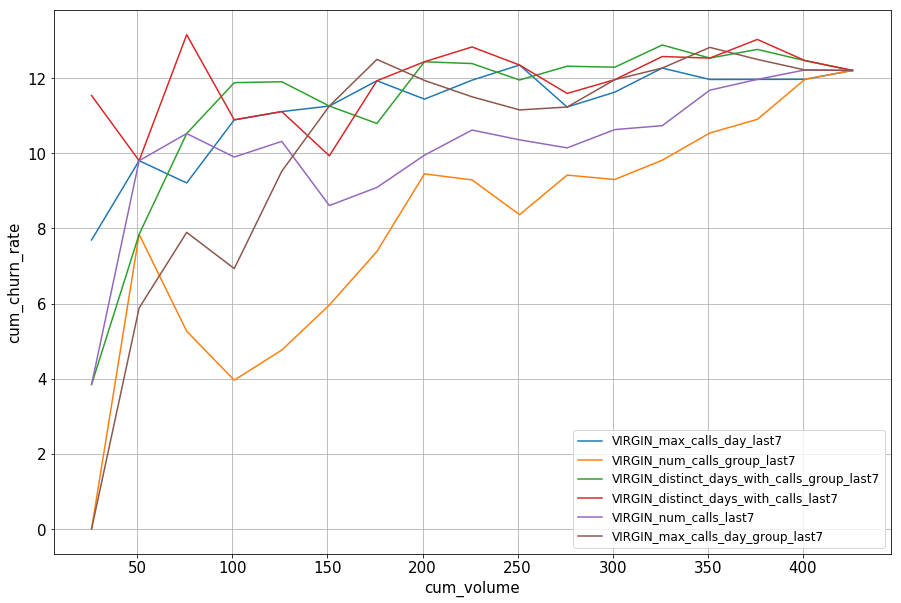

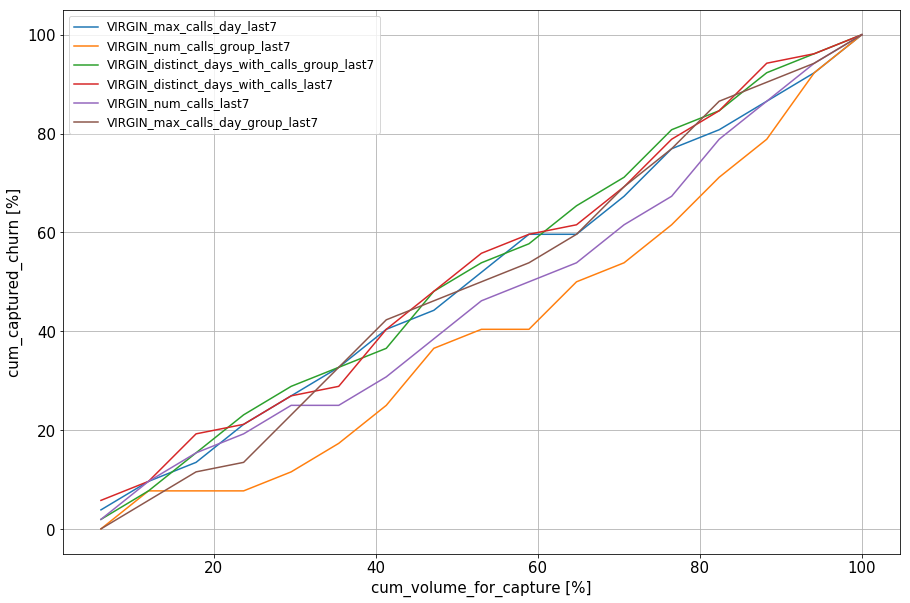

In [27]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params) 


import collections

od_corr_churn = collections.OrderedDict(sorted(dict_results_cdr_onlylast7.items()))

color = ["blue", "red", "green"]

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,10))

dfs = []
print("Graph1")
for lab, df in dict_results_cdr_onlylast7.items():
    
    if "5" in lab: continue
    print(lab)
    #color_ = "blue" if "lab0" in lab else ("red" if "lab1" in lab else "green")
    
    df = df.rename(columns={"cum_churn_rate": lab})
    ax.plot(df["cum_volume"], 100.0*df[lab], label=lab, linestyle="-" if "last7" in lab else "--")
ax.set_xlabel("cum_volume")
ax.set_ylabel("cum_churn_rate")
ax.legend(loc='best')
ax.grid()


fig,ax = plt.subplots(figsize=(15,10))

dfs = []
print("Graph2")

for lab, df in dict_results_cdr_onlylast7.items():
    if "5" in lab: continue
    print(lab)

    df = df.rename(columns={"cum_captured_churn": lab})
    ax.plot(100.0*df["cum_volume_for_capture"], 100.0*df[lab], label=lab, linestyle="-" if "last7" in lab else "--")
ax.set_xlabel("cum_volume_for_capture [%]")
ax.set_ylabel("cum_captured_churn [%]")
ax.legend(loc='best')
ax.grid()

Graph1
VIRGINTELCO_sum_count_last15
inc_VIRGINTELCO_max_count_d15
sum_distinct_days_with_navigation_comps_last15
inc_VIRGINTELCO_sum_count_d15
VIRGINTELCO_max_count_last15
VIRGINTELCO_distinct_days_with_navigation_last15
inc_VIRGINTELCO_distinct_days_with_navigation_d15
Graph2
VIRGINTELCO_sum_count_last15
inc_VIRGINTELCO_max_count_d15
sum_distinct_days_with_navigation_comps_last15
inc_VIRGINTELCO_sum_count_d15
VIRGINTELCO_max_count_last15
VIRGINTELCO_distinct_days_with_navigation_last15
inc_VIRGINTELCO_distinct_days_with_navigation_d15


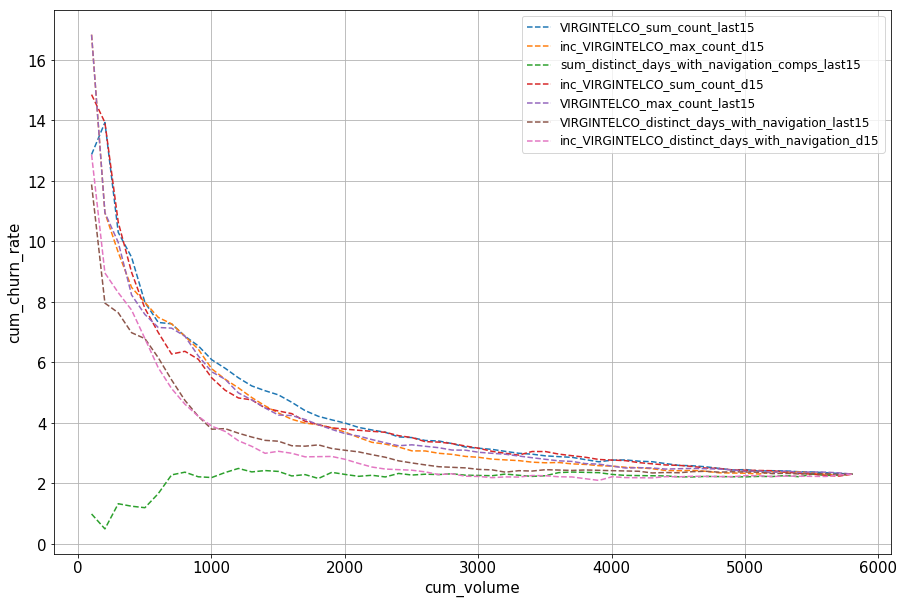

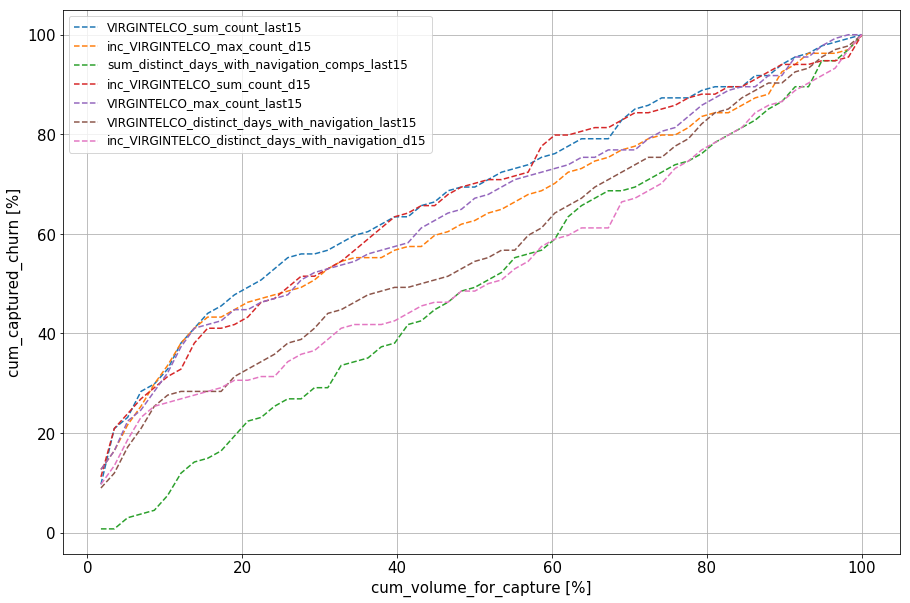

In [57]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params) 


import collections

od_corr_churn = collections.OrderedDict(sorted(dict_results_nav.items()))

color = ["blue", "red", "green"]

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,10))

dfs = []
print("Graph1")
for lab, df in dict_results_nav.items():
    
    if lab.endswith("7"): continue
    print(lab)
    #color_ = "blue" if "lab0" in lab else ("red" if "lab1" in lab else "green")
    
    df = df.rename(columns={"cum_churn_rate": lab})
    ax.plot(df["cum_volume"], 100.0*df[lab], label=lab, linestyle="-" if "last7" in lab else "--")
ax.set_xlabel("cum_volume")
ax.set_ylabel("cum_churn_rate")
ax.legend(loc='best')
ax.grid()


fig,ax = plt.subplots(figsize=(15,10))

dfs = []
print("Graph2")

for lab, df in dict_results_nav.items():
    if lab.endswith("7"): continue
    print(lab)

    df = df.rename(columns={"cum_captured_churn": lab})
    ax.plot(100.0*df["cum_volume_for_capture"], 100.0*df[lab], label=lab, linestyle="-" if "last7" in lab else "--")
ax.set_xlabel("cum_volume_for_capture [%]")
ax.set_ylabel("cum_captured_churn [%]")
ax.legend(loc='best')
ax.grid()

Graph1
inc_VIRGINTELCO_distinct_days_with_navigation_d7
VIRGINTELCO_sum_count_last7
VIRGINTELCO_max_count_last7
VIRGINTELCO_distinct_days_with_navigation_last7
sum_distinct_days_with_navigation_comps_last7
inc_VIRGINTELCO_max_count_d7
inc_VIRGINTELCO_sum_count_d7
Graph2
inc_VIRGINTELCO_distinct_days_with_navigation_d7
VIRGINTELCO_sum_count_last7
VIRGINTELCO_max_count_last7
VIRGINTELCO_distinct_days_with_navigation_last7
sum_distinct_days_with_navigation_comps_last7
inc_VIRGINTELCO_max_count_d7
inc_VIRGINTELCO_sum_count_d7


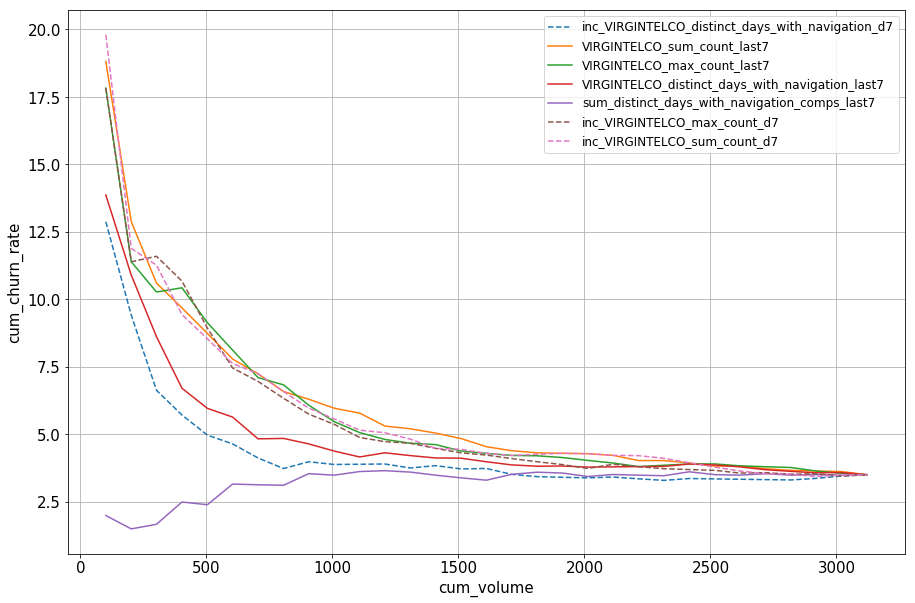

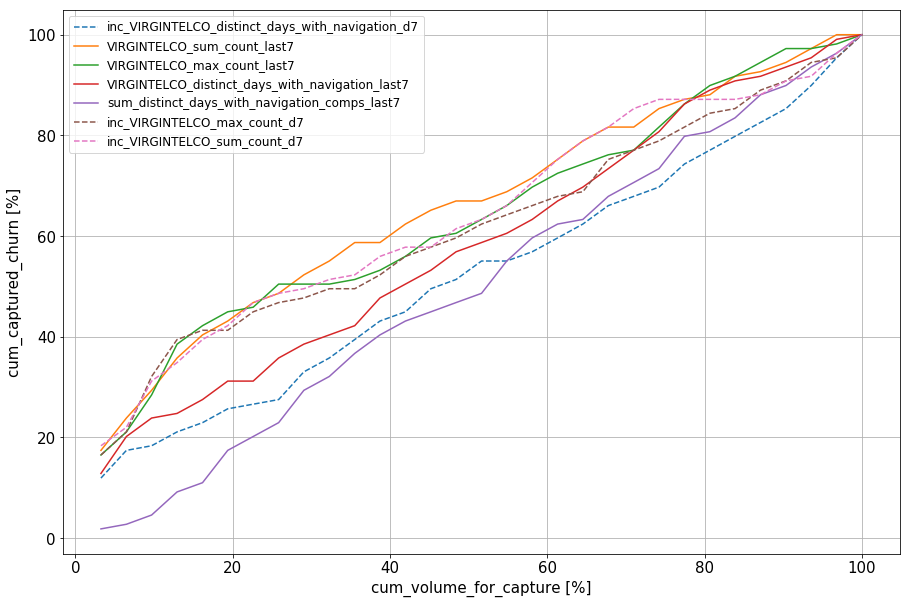

In [77]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params) 


import collections

od_corr_churn = collections.OrderedDict(sorted(dict_results_nav_onlylast7.items()))

color = ["blue", "red", "green"]

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,10))

dfs = []
print("Graph1")
for lab, df in dict_results_nav_onlylast7.items():
    
    if lab.endswith("5"): continue
    print(lab)
    #color_ = "blue" if "lab0" in lab else ("red" if "lab1" in lab else "green")
    
    df = df.rename(columns={"cum_churn_rate": lab})
    ax.plot(df["cum_volume"], 100.0*df[lab], label=lab, linestyle="-" if "last7" in lab else "--")
ax.set_xlabel("cum_volume")
ax.set_ylabel("cum_churn_rate")
ax.legend(loc='best')
ax.grid()


fig,ax = plt.subplots(figsize=(15,10))

dfs = []
print("Graph2")

for lab, df in dict_results_nav_onlylast7.items():
    if lab.endswith("5"): continue
    print(lab)

    df = df.rename(columns={"cum_captured_churn": lab})
    ax.plot(100.0*df["cum_volume_for_capture"], 100.0*df[lab], label=lab, linestyle="-" if "last7" in lab else "--")
ax.set_xlabel("cum_volume_for_capture [%]")
ax.set_ylabel("cum_captured_churn [%]")
ax.legend(loc='best')
ax.grid()

# tasa de evaporacion

In [59]:
[col_ for col_ in df_navcomp_all.columns if "portout_date_mob" in col_.lower()]

['portout_date_mob']

,bins,counts
0,3.466667,4.411765
1,4.933333,11.764706
2,6.400000,35.294118
3,7.866667,44.117647
4,9.333333,48.529412
5,10.800000,54.411765
6,12.266667,57.352941
7,13.733333,61.764706
8,15.200000,73.529412
9,16.666667,79.411765


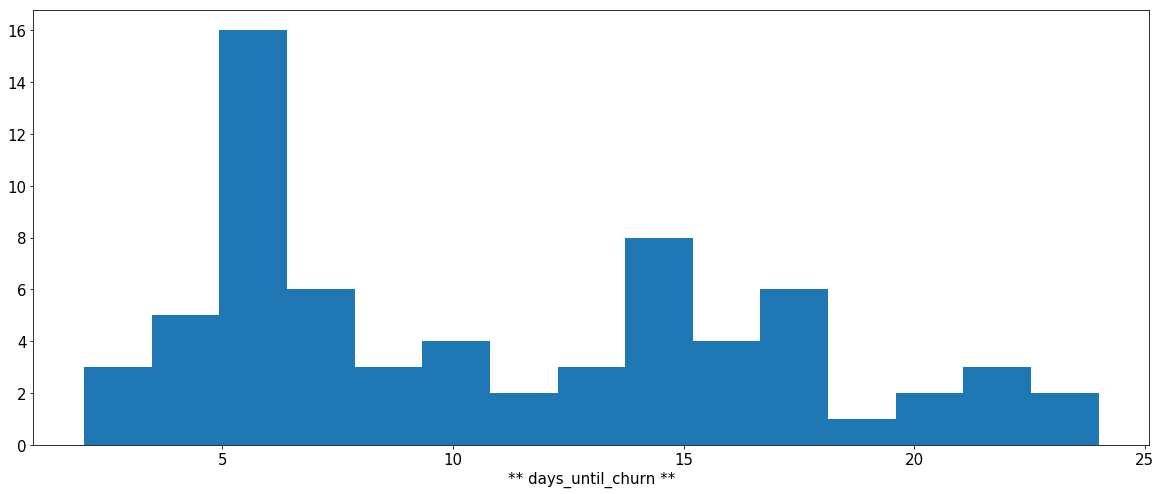

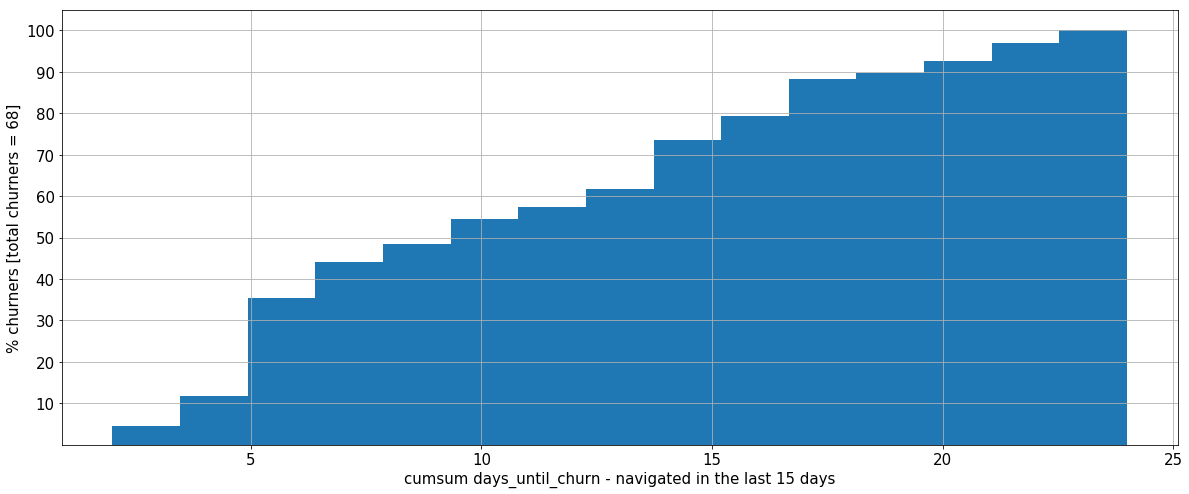

In [66]:
from churn_nrt.src.data.sopos_dxs import MobPort
from pyspark.sql.functions import datediff
tr_date_ = "20200620"
last_days = 14



#df_evap = df_navcomp_all.select("msisdn", "portout_date_mob", "label_virgin", 'VIRGINTELCO_max_days_since_navigation_last15').where(col("label_virgin")>0)
df_evap = df_cdr_all.select("msisdn", "portout_date_mob", "label_virgin", 'VIRGIN_max_days_since_call_last15').where(col("label_virgin")>0)


from pyspark.sql.functions import from_unixtime,unix_timestamp

df_evap = (df_evap.withColumn("days_until_sopo", when(col("portout_date_mob").isNotNull(), 
                                                                 datediff(col("portout_date_mob"),
                                                                          from_unixtime(unix_timestamp(lit(tr_date_), "yyyyMMdd")))).otherwise(-1)))



#df_evap = df_evap.withColumn("days_until_churn", col("days_until_sopo") + col('VIRGIN_max_days_since_navigation_last15'))
df_evap = df_evap.withColumn("days_until_churn", col("days_until_sopo") + col('VIRGIN_max_days_since_call_last15'))


col_ = "days_until_churn"
n = 15

bins, counts = df_evap.select(col_).rdd.flatMap(lambda x: x).histogram(n)

plt.figure()
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel("** {} **".format(col_))

total = df_evap.count()

import numpy as np
counts_cum = np.cumsum(counts)
counts_cum = [100.0 * cc/total for cc in counts_cum]

plt.figure()
plt.hist(bins[:-1], bins=bins, weights=counts_cum)
plt.grid(True)
plt.yticks(list(range(10,110,10))) 
plt.xlabel("cumsum {} - navigated in the last 15 days".format(col_))
plt.ylabel("% churners [total churners = {}]".format(total))

import pandas as pd
pd.DataFrame({"bins" : bins[1:], "counts" : counts_cum})

In [45]:
(spark.read.load("/data/udf/vf_es/churn_nrt/trigger_navcomp/").groupby("year", "month", "day")
          .agg(sql_count("*").alias("count"), 
               countDistinct("msisdn").alias("countDis"))
          .withColumn("verified", when(col("count") - col("countDis") == 0, "yes").otherwise("no"))
 .where(col("verified")=="no").withColumn("hdfs_path", concat(lit("/data/udf/vf_es/churn_nrt/trigger_navcomp/year="), col("year"), lit("/month="), col("month"), lit("/day="), col("day")))
 .sort(asc("year"), asc("month"), asc("day"))).show(1000, truncate=False)

+----+-----+---+-------+--------+--------+------------------------------------------------------------------+
|year|month|day|count  |countDis|verified|hdfs_path                                                         |
+----+-----+---+-------+--------+--------+------------------------------------------------------------------+
|2020|7    |17 |1927412|972893  |no      |/data/udf/vf_es/churn_nrt/trigger_navcomp/year=2020/month=7/day=17|
+----+-----+---+-------+--------+--------+------------------------------------------------------------------+



In [49]:
spark.read.load("/data/udf/vf_es/churn_nrt/trigger_navcomp/year=2020/month=7/day=17").drop_duplicates(["msisdn"]).count()

972893

In [16]:
df_calls = spark.read.load("/data/udf/vf_es/churn_nrt/callscomp/7/year=2020/month=4/day=14")
df_calls.select(*[col_ for col_ in df_calls.columns if "LEBARA" in col_]).show()

AnalysisException: u'Path does not exist: hdfs://nameservice1/data/udf/vf_es/churn_nrt/callscomp/7/year=2020/month=4/day=14;'

In [29]:
df_cb = spark.read.load("/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=5/day=14")
from churn_nrt.src.data.customer_base import add_postal_code
from churn_nrt.src.data.customer_base import add_ccaa
#df_cb = add_postal_code(spark, df_cb, "20200514")
df_cb = add_ccaa(spark, df_cb, "20200514")





[DataTemplate] __init__ | module name = customer | path = /data/udf/vf_es/churn_nrt/customer | verbose = True
[DataTemplate] get_module | module customer - for closing_day=20200514 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_columns': ['codigo_postal']}
[Customer] is_default_module | args: () | kwargs: {'add_columns': ['codigo_postal']}
[Customer] is_default_module | Module customer cannot be saved since 'add_columns' is different than None
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/customer/year=2020/month=5/day=14'. Starting generation...
[Customer] build_module | Requested additional_columns ['codigo_postal']
[DataTemplate] get_module | module 'customer' | Elapsed time in build_module function: 1.02057244778 minutes
[DataTemplate] get_module | module 'customer' | Module will not be saved (save=True and is_default_module()=False)
[DataTemplate] __init__ | module name = customer_base | path = /data/ud

In [ ]:
from churn_nrt.src.data.customers_data import CCAA_DICT
from pyspark.sql.functions import create_map, lit

cp_to_ccaa = { cp:ccaa for ccaa,cp_list in CCAA_DICT.items() for cp in cp_list}

In [32]:
# from churn_nrt.src.data.customers_data import CCAA_DICT
# from pyspark.sql.functions import create_map, lit

# cp_to_ccaa = { cp:ccaa for ccaa,cp_list in CCAA_DICT.items() for cp in cp_list}

# mapping_expr = create_map([lit(x) for x in chain(*cp_to_ccaa.items())])

# df_cb = df_cb.withColumn('ccaa', mapping_expr[df_cb['cp']]).fillna({"ccaa" : "unknown"})


north_ccaa = ["galicia",  "cataluna", "navarra", "asturias", "rioja"]
df_cb = df_cb.withColumn("flag_north_ccaa", when(col("ccaa").isin(*north_ccaa), 1).otherwise(0))

#df_cb.select("ccaa", "cp").show()

In [5]:
import churn_nrt.src.projects.models.


ImportError: No module named virgin.model_classes

In [22]:
df_navcomp_data2.dtypes

[('msisdn', 'string'), ('label_VIRGINTELCO_sum_count_last15', 'bigint')]

In [26]:
from churn_nrt.src.projects.models.virgin.model_classes import get_customer_base
from churn_nrt.src.data_utils.base_filters import keep_active_services
from churn_nrt.src.data.customer_base import CustomerAdditional
from churn_nrt.src.data_utils.base_filters import get_forbidden_orders_filter, get_churn_call_filter, get_non_recent_customers_filter, get_disconnection_process_filter
from churn_nrt.src.data.customer_base import add_ccaa
from churn_nrt.src.data_utils.Metadata import apply_metadata
from churn_nrt.src.data.navcomp_data import NavCompAdvData, NavCompData
from churn_nrt.src.data.calls_comps_data import CallsCompData, CallsCompAdvData

force_gen = False
calls_req = 0
target_days = 15

results_nav_last30 = {}

for closing_day in ["20200521", "20200531", "20200607", 
                    "20200614", 
                "20200621",
    "20200630", "20200707"
]:
    
    df_navcomp_data = NavCompData(spark, 30).get_module(closing_day, save=True, force_gen=force_gen).select("msisdn", "VIRGINTELCO_sum_count").drop_duplicates(["msisdn"])

    closing_day_B = move_date_n_days(closing_day, n=target_days)
    df_navcomp_data2 = (NavCompData(spark, 15).get_module(closing_day_B, save=True, force_gen=force_gen)
      .select("msisdn", "VIRGINTELCO_sum_count", "VIRGINTELCO_distinct_days_with_navigation")
            .withColumnRenamed("VIRGINTELCO_sum_count", "label_VIRGINTELCO_sum_count_last{}".format(target_days))
            .withColumnRenamed("VIRGINTELCO_distinct_days_with_navigation", "label_VIRGINTELCO_distinct_days_with_navigation_last{}".format(target_days)))

    inner_join = df_navcomp_data.where(col("VIRGINTELCO_sum_count" )>0).join(df_navcomp_data2.where(((col("label_VIRGINTELCO_sum_count_last{}".format(target_days)) >= 2) | (col("label_VIRGINTELCO_distinct_days_with_navigation_last{}".format(target_days)) >= 2))), on=["msisdn"], how="inner")
    
    results_nav_last30[closing_day] = [df_navcomp_data.where(col("VIRGINTELCO_sum_count" )>0).count(), inner_join.count(), df_navcomp_data2.where(((col("label_VIRGINTELCO_sum_count_last{}".format(target_days)) >= 2) | (col("label_VIRGINTELCO_distinct_days_with_navigation_last{}".format(target_days)) >= 2))).count()]

    print("RESULTADOS - {}".format(closing_day))
    pprint.pprint(results_nav_last30)                             

[DataTemplate] __init__ | module name = navcomp/30 | path = /data/udf/vf_es/churn_nrt/navcomp/30 | verbose = True
[DataTemplate] get_module | module navcomp/30 - for closing_day=20200521 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[NavCompData] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp/30/year=2020/month=5/day=21'
[DataTemplate] __init__ | module name = navcomp/15 | path = /data/udf/vf_es/churn_nrt/navcomp/15 | verbose = True
[DataTemplate] get_module | module navcomp/15 - for closing_day=20200605 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[NavCompData] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp/15/year=2020/month=6/day=5'
RESULTADOS - 20200521
{'20200521': [327, 156, 3214]}
[DataTemplate] __init__ | module name = navc

In [15]:

from churn_nrt.src.projects.models.virgin.model_classes import get_customer_base
from churn_nrt.src.data_utils.base_filters import keep_active_services
from churn_nrt.src.data.customer_base import CustomerAdditional
from churn_nrt.src.data_utils.base_filters import get_forbidden_orders_filter, get_churn_call_filter, get_non_recent_customers_filter, get_disconnection_process_filter
from churn_nrt.src.data.customer_base import add_ccaa
from churn_nrt.src.data_utils.Metadata import apply_metadata
from churn_nrt.src.data.navcomp_data import NavCompAdvData, NavCompData
from churn_nrt.src.data.calls_comps_data import CallsCompData, CallsCompAdvData

force_gen = False
calls_req = 0

for closing_day in ["20200521", "20200531", "20200607", 
                    "20200614", 
                "20200621",
     "20200630", "20200707"
]:
    
        start_time_iter = time.time()
        print("CSANC109__base", closing_day)

        base_df = CustomerBase(spark).get_module(closing_day, save=False, save_others=False, add_tgs=False).filter(col('rgu') == 'mobile').drop_duplicates(["msisdn"])
        base_df = base_df.where((col('rgu') == 'mobile') & (col("cod_estado_general").isin("01", "09")) & (col("srv_basic").isin("MRSUI", "MPSUI") == False))\

        base_df = base_df.select("num_cliente", "msisdn", "nif_cliente")

        print("[TriggerMyVfModel] get_set | - - - - - - - - get_non_recent_customers_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))
        tr_active_filter = get_non_recent_customers_filter(spark, closing_day, 90)

        print("[TriggerMyVfModel] get_set | - - - - - - - - get_disconnection_process_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))
        tr_disconnection_filter = get_disconnection_process_filter(spark, closing_day, 90)

        print("[TriggerMyVfModel] get_set | - - - - - - - -  get_churn_call_filter for closing_day={} n_days={} level={} - - - - - - - -".format(closing_day, 90, "msisdn"))
        tr_churn_call_filter = get_churn_call_filter(spark, closing_day, 90, 'msisdn')

        tr_forbidden = get_forbidden_orders_filter(spark, closing_day, level="nif", verbose=False, only_active=True)

        tr_set = (base_df.join(tr_active_filter, ['msisdn'], 'inner')
            .join(tr_disconnection_filter, ['nif_cliente'], 'inner')
            .join(tr_churn_call_filter, ['msisdn'], 'inner')
            .join(tr_forbidden, ['nif_cliente'], 'inner'))

        tr_set = tr_set.cache()
        print('CheckA  - Volume: ' + str(tr_set.count()) + ' - Number of msisdn: ' + str(tr_set.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(
        tr_set.select('nif_cliente').distinct().count()) + ' - Number of NCs: ' + str(tr_set.select('num_cliente').distinct().count()))



        start_time = time.time()
        df_navcomp_data = NavCompData(spark, 30).get_module(closing_day, save=True, force_gen=force_gen).select("msisdn", "VIRGINTELCO_sum_count").drop_duplicates(["msisdn"])
        df_calls = CallsCompData(spark, 30).get_module(closing_day, save=True, force_gen=force_gen).select("msisdn", "callscomp_VIRGIN_num_calls").drop_duplicates(["msisdn"])


        tr_set = tr_set.join(df_navcomp_data, on=["msisdn"], how="left")
        if calls_req == 1:
            tr_set = tr_set.join(df_calls, on=["msisdn"], how="left")

        tr_set = apply_metadata(NavCompData(spark, 30).get_metadata(), tr_set)
        if calls_req == 1:
            tr_set = apply_metadata(CallsCompData(spark, 30).get_metadata(), tr_set)
            tr_set = tr_set.fillna({"VIRGINTELCO_sum_count" : 0, "callscomp_VIRGIN_num_calls" : 0})
        else:
            tr_set = tr_set.fillna({"VIRGINTELCO_sum_count" : 0})


        tr_set = tr_set.cache()
        print('CheckB  - Volume: ' + str(tr_set.count()) + ' - Number of msisdn: ' + str(tr_set.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(
        tr_set.select('nif_cliente').distinct().count()) + ' - Number of NCs: ' + str(tr_set.select('num_cliente').distinct().count()))
        

        if calls_req == 1:
            tr_set = tr_set.where( (col("VIRGINTELCO_sum_count" )==0) & (col("callscomp_VIRGIN_num_calls" )==0 ))
        else:
            tr_set = tr_set.where( (col("VIRGINTELCO_sum_count" )==0))

        tr_set = tr_set.cache()
        print('CheckC - Volume: ' + str(tr_set.count()) + ' - Number of msisdn: ' + str(tr_set.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(
        tr_set.select('nif_cliente').distinct().count()) + ' - Number of NCs: ' + str(tr_set.select('num_cliente').distinct().count()))

        if calls_req == 1:
            from churn_nrt.src.projects.models.virgin.model_classes import set_label
            tr_set = set_label(spark, closing_day, tr_set, target_days, force_gen=force_gen)
        else:
            tr_set = set_label_nocalls(spark, closing_day, tr_set, target_days, force_gen=force_gen)

        tr_set = tr_set.cache()
        print('CheckD  - Volume: ' + str(tr_set.count()) + ' - Number of msisdn: ' + str(tr_set.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(
        tr_set.select('nif_cliente').distinct().count()) + ' - Number of NCs: ' + str(tr_set.select('num_cliente').distinct().count()))
            
        vol1 = tr_set.count() # vol total
        vol2 = tr_set.where(col("label")==1).count() # vol with label=1
        print("+++", closing_day, vol1, vol2)
        results[closing_day] = [vol1, vol2]

        print("RESULTADOS - {}".format(closing_day))
        pprint.pprint(results)
        print("ITER Elapsed time {} minutes".format((time.time() - start_time_iter) / 60.0))

('CSANC109__base', '20200621')
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200621 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_tgs': False}
[CustomerBase] is_default_module | args: () | kwargs: {'add_tgs': False}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=21'
[TriggerMyVfModel] get_set | - - - - - - - - get_non_recent_customers_filter for closing_day=20200621 n_days=90 - - - - - - - -
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200621 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_tgs': False}
[CustomerBase] is_defaul

Py4JJavaError: An error occurred while calling o3601.cache.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.joins.UnsafeHashedRelation.org$apache$spark$sql$execution$joins$UnsafeHashedRelation$$read(HashedRelation.scala:261)
	at org.apache.spark.sql.execution.joins.UnsafeHashedRelation$$anonfun$read$1.apply$mcV$sp(HashedRelation.scala:281)
	at org.apache.spark.sql.execution.joins.UnsafeHashedRelation$$anonfun$read$1.apply(HashedRelation.scala:281)
	at org.apache.spark.sql.execution.joins.UnsafeHashedRelation$$anonfun$read$1.apply(HashedRelation.scala:281)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1360)
	at org.apache.spark.sql.execution.joins.UnsafeHashedRelation.read(HashedRelation.scala:280)
	at com.esotericsoftware.kryo.serializers.DefaultSerializers$KryoSerializableSerializer.read(DefaultSerializers.java:511)
	at com.esotericsoftware.kryo.serializers.DefaultSerializers$KryoSerializableSerializer.read(DefaultSerializers.java:503)
	at com.esotericsoftware.kryo.Kryo.readClassAndObject(Kryo.java:790)
	at org.apache.spark.serializer.KryoDeserializationStream.readObject(KryoSerializer.scala:278)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:216)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1241)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:552)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$readBroadcastBlock$1$$anonfun$apply$2.apply(TorrentBroadcast.scala:214)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$readBroadcastBlock$1.apply(TorrentBroadcast.scala:211)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1360)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:207)
	at org.apache.spark.broadcast.TorrentBroadcast._value$lzycompute(TorrentBroadcast.scala:66)
	at org.apache.spark.broadcast.TorrentBroadcast._value(TorrentBroadcast.scala:66)
	at org.apache.spark.broadcast.TorrentBroadcast.getValue(TorrentBroadcast.scala:96)
	at org.apache.spark.broadcast.Broadcast.value(Broadcast.scala:70)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareBroadcast(BroadcastHashJoinExec.scala:137)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.codegenInner(BroadcastHashJoinExec.scala:232)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doConsume(BroadcastHashJoinExec.scala:102)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.ProjectExec.consume(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.ProjectExec.doConsume(basicPhysicalOperators.scala:65)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.consume(SortMergeJoinExec.scala:36)


In [10]:
[col_ for col_ in spark.read.load("/data/udf/vf_es/churn_nrt/callscomp/30/year=2020/month=5/day=22").columns if "LEBARA" in col_]

['LEBARA_MOVIL_num_calls',
 'LEBARA_MOVIL_max_calls_day',
 'LEBARA_MOVIL_max_days_since_call',
 'LEBARA_MOVIL_min_days_since_call',
 'LEBARA_MOVIL_distinct_days_with_calls']

In [4]:
[col_ for col_ in .columns if "tgs" in col_]

['tgs_days_until_fecha_fin_dto_agg_mean',
 'tgs_sum_ind_over_use_agg_mean',
 'tgs_has_discount_agg_mean',
 'tgs_sum_ind_under_use_agg_mean',
 'tgs_days_until_f_fin_bi_agg_mean',
 'tgs_days_since_f_inicio_bi_agg_mean',
 'tgs_days_since_f_inicio_bi_exp_agg_mean',
 'tgs_days_until_f_fin_bi_exp_agg_mean']

In [7]:
df_price = spark.read.load("/user/csanc109/projects/churn/data/price_sens_new_product_mobile_0_20/df_lab8.1_20191130_20200619_135122")
df_price.where(col("tgs_days_until_fecha_fin_dto_agg_mean")<150).count()

1666109

In [6]:
df_cb = spark.read.load("/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=7")

df_cb.drop_duplicates(["msisdn"]).filter(col('rgu') == 'mobile').count()

5719956

In [9]:
df_cb.drop_duplicates(["msisdn"]).groupby('rgu').count().show()

+----------+-------+
|       rgu|  count|
+----------+-------+
|       fbb|2237909|
|    mobile|5719956|
|        tv|1318372|
|bam_mobile|      8|
|     fixed|2727722|
|       bam| 436270|
+----------+-------+



In [58]:
[col_ for col_ in spark.read.load("/data/udf/vf_es/churn_nrt/navcomp/15/year=2020/month=6/day=21").columns if "LEBARA" in col_]

AnalysisException: u'Path does not exist: hdfs://nameservice1/data/udf/vf_es/churn_nrt/navcomp/15/year=2020/month=6/day=21;'

In [27]:
tr_set = spark.read.load("/data/udf/vf_es/churn_nrt/trigger_virgin/year=2020/month=6/day=14")

In [42]:
from churn_nrt.src.data_utils.Metadata import Metadata

from churn_nrt.src.projects.models.virgin.metadata import METADATA_STANDARD_MODULES, get_metadata

metadata_obj = Metadata(spark, get_metadata, ["msisdn"], sources=None)

all_cols = metadata_obj.get_cols(type_="all")



# when working with different versions  just to be sure "all_cols" contains columns existing in df
list(set(all_cols) ^ set(tr_set.columns))


[metadata] get_metadata 
[metadata] Using standard modules navcomp_adv,callscomp_adv,customer
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] __init__ | module name = customer_additional/90 | path = /data/udf/vf_es/churn_nrt/customer_additional/90 | verbose = True
[metadata] Adding customer metadata
[DataTemplate] __init__ | module name = navcomp_adv | path = /data/udf/vf_es/churn_nrt/navcomp_adv | verbose = True
[DataTemplate] __init__ | module name = navcomp/7 | path = /data/udf/vf_es/churn_nrt/navcomp/7 | verbose = True
[NavCompData] get_metadata | Building metadata dataframe
[DataTemplate] __init__ | module name = navcomp/15 | path = /data/udf/vf_es/churn_nrt/navcomp/15 | verbose = True
[NavCompData] get_metadata | Building metadata dataframe
[DataTemplate] __init__ | module name = navcomp/30 | path = /data/udf/vf_es/churn_nrt/navcomp/30 | verbose = True
[NavCompData] get_metadata | Building meta

['callscomp_most_consulted_group_dd30',
 'callscomp_most_consulted_group_last30',
 'most_consulted_operator_dd30',
 'most_consulted_operator_last60',
 'callscomp_most_consulted_group_last7',
 'callscomp_most_consulted_group_last15',
 'callscomp_most_consulted_comp_last7',
 'callscomp_most_consulted_comp_last60',
 'callscomp_most_consulted_comp_last15',
 'most_consulted_operator_last7',
 'most_consulted_operator_last30',
 'callscomp_most_consulted_group_last60',
 'callscomp_most_consulted_comp_dd30',
 'nif_cliente',
 'callscomp_most_consulted_comp_last30',
 'most_consulted_operator_last15']

In [41]:
df_metadata = get_metadata(spark, sources=['callscomp_adv'])

[metadata] get_metadata 
[DataTemplate] __init__ | module name = callscomp_adv | path = /data/udf/vf_es/churn_nrt/callscomp_adv | verbose = True
[DataTemplate] __init__ | module name = callscomp/7 | path = /data/udf/vf_es/churn_nrt/callscomp/7 | verbose = True
[CallsCompData] get_metadata | Building metadata dataframe
[DataTemplate] __init__ | module name = callscomp/15 | path = /data/udf/vf_es/churn_nrt/callscomp/15 | verbose = True
[CallsCompData] get_metadata | Building metadata dataframe
[DataTemplate] __init__ | module name = callscomp/30 | path = /data/udf/vf_es/churn_nrt/callscomp/30 | verbose = True
[CallsCompData] get_metadata | Building metadata dataframe
[DataTemplate] __init__ | module name = callscomp/30 | path = /data/udf/vf_es/churn_nrt/callscomp/30 | verbose = True
[CallsCompData] get_metadata | Building metadata dataframe
[DataTemplate] __init__ | module name = callscomp/60 | path = /data/udf/vf_es/churn_nrt/callscomp/60 | verbose = True
[CallsCompData] get_metadata | 

AttributeError: 'NoneType' object has no attribute 'count'

In [ ]:
df_metadata.show()

In [43]:
"callscomp_most_consulted_comp_last15" in all_cols

False

In [31]:
list(set(all_cols) - set(tr_set.columns))


[]

In [32]:
list(set(tr_set.columns) - set(all_cols))

['nif_cliente']

In [63]:
customer_feats = list(set(metadata_obj.get_cols(sources=['customer']) + ['nif_cliente', "msisdn"]))
customer_feats

[metadata] get_metadata 
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] __init__ | module name = customer_additional/90 | path = /data/udf/vf_es/churn_nrt/customer_additional/90 | verbose = True
[metadata] Adding customer metadata


[u'segment_nif',
 u'age_disc',
 'msisdn',
 u'nb_fixed_services_nif',
 u'age',
 u'nb_rgus_nif',
 u'blindaje',
 u'nb_prepaid_services_nif',
 u'nb_fbb_services_nif',
 'nif_cliente',
 u'nb_bam_services_nif',
 u'nb_tv_services_nif',
 u'nb_bam_mobile_services_nif',
 u'tgs_days_until_f_fin_bi',
 u'nb_mobile_services_nif',
 u'tgs_has_discount',
 u'flag_north_ccaa']

In [32]:
spark.read.load("/data/udf/vf_es/netscout/dailyMSISDNApplicationName/year=2020/month=6").groupby("day").agg(sql_count("*").alias("count"), 
                                                                                                            countDistinct("subscriber_msisdn").alias("distinct")).sort(asc("day")).show(50)

+---+---------+--------+
|day|    count|distinct|
+---+---------+--------+
|  1|458040683| 8877806|
|  2|468057929| 8949167|
|  3|326182200| 8442047|
|  4|392824045| 8267331|
|  5|410132129| 8501850|
|  6|390062208| 8288616|
|  7|358714959| 8037148|
|  8|422486829| 8839007|
|  9|416844554| 8779398|
| 10|414366693| 8801352|
| 11|405321712| 8700924|
| 12|414501650| 8763491|
| 13|395236205| 8502491|
| 14|371963805| 8291894|
| 15|441891287| 8841746|
| 16|452033880| 8836869|
| 17|453114667| 8841793|
| 18|453087016| 8859812|
| 19|468872122| 8903291|
| 20|440767653| 8639167|
| 21|423864651| 8472402|
| 22|460829085| 8889639|
| 23|470128550| 8926838|
| 24|455588057| 8788373|
| 25|475998203| 9019045|
| 26|490146441| 9080503|
| 27|465280700| 8812158|
| 28|448528710| 8618021|
| 29|485890829| 9099344|
| 30|502040062| 9177872|
+---+---------+--------+



In [ ]:
def process_one_day(spark, path_, closing_day):
    df_master_comp = spark.read.load("/data/raw/vf_es/lookup/COMPETITOR_TELEPHONE/1.0/parquet")
    df_master_comp = df_master_comp.withColumn("COMPETIDOR", when(col("COMPETIDOR").rlike("MASM.VIL"), "MASMOVIL").otherwise(col("COMPETIDOR")))
    df_master_comp = df_master_comp.withColumn("GROUP", when(col("GROUP").rlike("MASM.VIL"), "MASMOVIL").otherwise(col("GROUP")))

    df_cdr = spark.read.load(path_)
    df_cdr = df_cdr.join(df_master_comp, on=(df_master_comp["TELEPHONE_NUMBER"] == df_cdr["NRSECUN"]), how="inner").where(col("CDSENLLA") == "OL")

    from churn_nrt.src.data.customer_base import CustomerBase
    df_cb = CustomerBase(spark).get_module(closing_day)

    df_cdr = df_cdr.join(df_cb.select("msisdn"), on=(df_cdr["NRPRIMA"] == df_cb["msisdn"]), how="inner")

    df_gr = (df_cdr.groupBy("msisdn", "GROUP", "COMPETIDOR", "DTINILLA").agg(sql_count("*").alias("num_calls"), sql_sum("TMDURLLA").alias("sum_duration"),
        sql_avg("TMDURLLA").alias("avg_duration")).withColumn("days_since_call",
                                                              datediff(from_unixtime(unix_timestamp(lit(closing_day), "yyyyMMdd")), from_unixtime(unix_timestamp(col("DTINILLA"), "yyyyMMdd"))).cast(
                                                                  "double")))

    return df_gr

In [74]:
def get_first_date(spark):
    
    df_master_comp = spark.read.load("/data/raw/vf_es/lookup/COMPETITOR_TELEPHONE/1.0/parquet")
    df_master_comp = df_master_comp.where(col("COMPETIDOR").rlike("VIRGIN"))

    df_cdr = spark.read.load("/data/raw/vf_es/mediated_cdr/NAVAJO/1.0/parquet/year=2020/")
    df_cdr = df_cdr.join(df_master_comp, on=(df_master_comp["TELEPHONE_NUMBER"] == df_cdr["NRSECUN"]), how="inner").where(col("CDSENLLA") == "OL")

#     from churn_nrt.src.data.customer_base import CustomerBase
#     df_cb = CustomerBase(spark).get_module(closing_day)
#     df_cdr = df_cdr.join(df_cb.select("msisdn"), on=(df_cdr["NRPRIMA"] == df_cb["msisdn"]), how="inner")

#     df_gr = (df_cdr.groupBy("msisdn", "GROUP", "COMPETIDOR", "DTINILLA").agg(sql_count("*").alias("num_calls"), sql_sum("TMDURLLA").alias("sum_duration"),
#         sql_avg("TMDURLLA").alias("avg_duration")).withColumn("days_since_call",
#                                                               datediff(from_unixtime(unix_timestamp(lit(closing_day), "yyyyMMdd")), from_unixtime(unix_timestamp(col("DTINILLA"), "yyyyMMdd"))).cast(
#                                                                   "double")))
    
    
    
    navcomp_last_date = (df_cdr.withColumn('mydate', col("DTINILLA"))#concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')))\
    .select(sql_min(col('mydate')).alias('last_date'))\
    .rdd\
    .first())['last_date']

    return navcomp_last_date

get_first_date(spark)

u'20200601'

In [9]:

from churn_nrt.src.utils.date_functions import move_date_n_days
import pprint
from churn_nrt.src.data.customer_base import CustomerBase


results = {}

for closing_day in ["20200521", "20200531", "20200607", 
                    "20200614", "20200621", "20200630", "20200707"]:

    starting_day = move_date_n_days(closing_day, n=-30)

    df_master_comp = spark.read.load("/data/raw/vf_es/lookup/COMPETITOR_TELEPHONE/1.0/parquet")
    df_master_comp = df_master_comp.where(col("COMPETIDOR").rlike("VIRGIN"))

    df_cdr = spark.read.load("/data/raw/vf_es/mediated_cdr/NAVAJO/1.0/parquet/year=2020/").where( (col("DTINILLA")>=starting_day) & (col("DTINILLA")<=closing_day))
    df_cdr = df_cdr.join(df_master_comp, on=(df_master_comp["TELEPHONE_NUMBER"] == df_cdr["NRSECUN"]), how="inner").where(col("CDSENLLA") == "OL")
    
    df_cb = CustomerBase(spark).get_module(closing_day)
    df_cdr = df_cdr.join(df_cb.select("msisdn"), on=(df_cdr["NRPRIMA"] == df_cb["msisdn"]), how="inner")
   
    df_gr = (df_cdr.groupBy("NRPRIMA", "GROUP", "COMPETIDOR", "DTINILLA").agg(sql_count("*").alias("num_calls")))

    results[closing_day] = [df_gr.select("NRPRIMA").distinct().count(), df_gr.select("NRPRIMA").count()]
    pprint.pprint(results)
            
    #     df_gr.groupby("DTINILLA").agg(sql_sum("num_calls").alias("sum_calls"), 
    #                              countDistinct("NRPRIMA").alias("distinct")).sort(asc("DTINILLA")).show(500)

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200521 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=5/day=21'


KeyboardInterrupt: 

In [5]:
from pyspark.sql.window import Window

In [4]:
path_to_read = "/data/udf/vf_es/netscout/dailyMSISDNApplicationName/"

print("[Info] Reading from {}".format(path_to_read))

repart_navigdf = spark.read.parquet(path_to_read)

apps_names = ["WEB_" + op + "_" + p for op in ["VIRGINTELCO"] for p in ["HTTP", "HTTPS"]]

repart_navigdf = repart_navigdf \
    .withColumn('total_data', col("SUM_userplane_upload_bytes_count") + col("SUM_userplane_download_bytes_count")) \
    .filter((col("subscriber_msisdn").isNotNull()) & (col("application_name").contains('VIRGINTELCO')) & (col('total_data') > 524288)) \
        .withColumn("event_date", concat(col('year'), lit("-"), lpad(col('month'), 2, '0'), lit("-"), lpad(col('day'), 2, '0'))) \
        .withColumn("formatted_event_date", from_unixtime(unix_timestamp(col("event_date"), "yyyy-MM-dd"))) \
        .filter((col("formatted_event_date") >= from_unixtime(unix_timestamp(lit("20200601"), "yyyyMMdd"))) & (col("formatted_event_date") <= from_unixtime(unix_timestamp(lit("20200630"), "yyyyMMdd")))) \
 #   .where(col("application_name").isin(apps_names))\
    
repart_navigdf.select("application_name").where(col("application_name").isin("WEB_VIRGINTELCO_HTTP", "WEB_VIRGINTELCO_HTTPS").show(10000)

[Info] Reading from /data/udf/vf_es/netscout/dailyMSISDNApplicationName/
+--------------------+
|    application_name|
+--------------------+
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VIRGINTELCO_HTTP|
|WEB_VI

In [8]:
repart_navigdf.select("application_name").where(~col("application_name").isin(["WEB_VIRGINTELCO_HTTP", "WEB_VIRGINTELCO_HTTPS"])).show(1)

+----------------+
|application_name|
+----------------+
+----------------+



In [30]:
from collections import OrderedDict

resultsss = {
           
'20200521': [5725178,
              3657,
              5535587,
              3446,
              5451624,
              3367,
              5322277,
              3143,
              5233709,
              3064,
              5233406,
              2909],
 '20200531': [5725973,
              3260,
              5601766,
              3167,
              5464445,
              3089,
              5339021,
              2874,
              5257011,
              2808,
              5251398,
              2246],
           
  '20200607': [5716653,
              2980,
              5553376,
              2834,
              5474633,
              2767,
              5351240,
              2576,
              5268534,
              2511,
              5259705,
              2050],
    
     '20200614': [5713566,
              3150,
              5545680,
              3012,
              5463238,
              2941,
              5342686,
              2709,
              5260998,
              2646,
              5250558,
              2234],
    
    '20200621': [5713980,
              3386,
              5549491,
              3245,
              5471926,
              3170,
              5347740,
              2913,
              5262302,
              2856,
              5250067,
              2322],
 '20200630': [5707310,
              3478,
              5546720,
              3309,
              5465777,
              3218,
              5331337,
              2935,
              5234901,
              2858,
              5224077,
              2290],
     '20200707': [5694951,
              3120,
              5519444,
              2981,
              5434838,
              2876,
              5296915,
              2609,
              5195076,
              2538,
              5185188,
              1887],
    
    '20200714': [5684345,
              2971,
              5492326,
              2794,
              5402588,
              2699,
              5260748,
              2457,
              5150656,
              2394,
              5140908,
              1826]





}
           
           
resultsss = OrderedDict(sorted(resultsss.items()))
           
           
           

import pprint
pprint.pprint(resultsss)

OrderedDict([('20200521', [5725178, 3657, 5535587, 3446, 5451624, 3367, 5322277, 3143, 5233709, 3064, 5233406, 2909]), ('20200531', [5725973, 3260, 5601766, 3167, 5464445, 3089, 5339021, 2874, 5257011, 2808, 5251398, 2246]), ('20200607', [5716653, 2980, 5553376, 2834, 5474633, 2767, 5351240, 2576, 5268534, 2511, 5259705, 2050]), ('20200614', [5713566, 3150, 5545680, 3012, 5463238, 2941, 5342686, 2709, 5260998, 2646, 5250558, 2234]), ('20200621', [5713980, 3386, 5549491, 3245, 5471926, 3170, 5347740, 2913, 5262302, 2856, 5250067, 2322]), ('20200630', [5707310, 3478, 5546720, 3309, 5465777, 3218, 5331337, 2935, 5234901, 2858, 5224077, 2290]), ('20200707', [5694951, 3120, 5519444, 2981, 5434838, 2876, 5296915, 2609, 5195076, 2538, 5185188, 1887]), ('20200714', [5684345, 2971, 5492326, 2794, 5402588, 2699, 5260748, 2457, 5150656, 2394, 5140908, 1826])])


In [29]:
from churn_nrt.src.utils.date_functions import move_date_n_days
move_date_n_days("20200531", -90)

'20200302'

In [31]:
for k,v in resultsss.items():
    print(k,v)

('20200521', [5725178, 3657, 5535587, 3446, 5451624, 3367, 5322277, 3143, 5233709, 3064, 5233406, 2909])
('20200531', [5725973, 3260, 5601766, 3167, 5464445, 3089, 5339021, 2874, 5257011, 2808, 5251398, 2246])
('20200607', [5716653, 2980, 5553376, 2834, 5474633, 2767, 5351240, 2576, 5268534, 2511, 5259705, 2050])
('20200614', [5713566, 3150, 5545680, 3012, 5463238, 2941, 5342686, 2709, 5260998, 2646, 5250558, 2234])
('20200621', [5713980, 3386, 5549491, 3245, 5471926, 3170, 5347740, 2913, 5262302, 2856, 5250067, 2322])
('20200630', [5707310, 3478, 5546720, 3309, 5465777, 3218, 5331337, 2935, 5234901, 2858, 5224077, 2290])
('20200707', [5694951, 3120, 5519444, 2981, 5434838, 2876, 5296915, 2609, 5195076, 2538, 5185188, 1887])
('20200714', [5684345, 2971, 5492326, 2794, 5402588, 2699, 5260748, 2457, 5150656, 2394, 5140908, 1826])


In [23]:
from churn_nrt.src.projects.analysis.virgin_launch.virgin_prevention import get_virgin_navs
from churn_nrt.src.utils.date_functions import move_date_n_days
closing_day = "20200630"
closing_day_B = move_date_n_days(closing_day, n=15)
df_v_n = get_virgin_navs(spark, closing_day, closing_day_B)
A = df_v_n.where((col('sum_count') >= 2) | (col('num_distinct_days') >= 2)).count()

from churn_nrt.src.data.customer_base import CustomerBase
basedf = CustomerBase(spark).get_module(closing_day, save=False, save_others=False, force_gen=False).select('msisdn', 'nif_cliente').drop_duplicates(["msisdn"])
from churn_nrt.src.data_utils.base_filters import keep_active_services
basedf = keep_active_services(basedf)

B = df_v_n.join(basedf, ['msisdn'], 'inner').where((col('sum_count') >= 2) | (col('num_distinct_days') >= 2)).count()
print(A,B)
print(A,B) # (4831, 2567)

[Info] Reading from /data/udf/vf_es/netscout/dailyMSISDNApplicationName/
with new filter
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200630 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=6/day=30'
(5949, 3154)
(5949, 3154)


In [8]:
target_days = 15
from churn_nrt.src.data.navcomp_data import NavCompAdvData, NavCompData
df_navcomp_data = NavCompData(spark, 15).get_module(closing_day_B, save=True, force_gen=True).drop_duplicates(["msisdn"])
df_navcomp_data.where( ((col("VIRGINTELCO_sum_count")>=2) | (col("VIRGINTELCO_distinct_days_with_navigation") >= 2))).count()

[DataTemplate] __init__ | module name = navcomp/15 | path = /data/udf/vf_es/churn_nrt/navcomp/15 | verbose = True
[DataTemplate] get_module | module navcomp/15 - for closing_day=20200629 save=True save_others=True force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[NavCompData] check_valid_params | Params ok
[DataTemplate] get_module | Module will be generated since force_gen parameter was set to True. An existing module in path will be ignored
[NavCompData] build_module | starting_date: 20200614 - ending_date: 20200629 - level: msisdn
[NavCompData] build_module |  Starting the computation of the feats
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200629 save=True save_others=True force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Mod

KeyboardInterrupt: 

# Correlation between vars

In [4]:
from churn_nrt.src.projects_utils.models.modeler_feat_selection import feature_selection_correlation, feature_selection_rf

df = spark.read.load("/data/udf/vf_es/churn_nrt/trigger_virgin/year=2020/month=5/day=30")
cols_to_filter = df.columns

A = feature_selection_correlation(df, cols_to_filter, threshold=0.8, label_col = 'label', pcg = 1.0)

A

[Info] Number of rows in the DF: 5185188
[Info] Calculating correlation for 2236 variables


['callscomp_TALKOUT_min_days_since_call_dd30',
 'inc_callscomp_TALKOUT_max_calls_day_d15',
 'callscomp_PEPEPHONE_num_calls_group_last30',
 'callscomp_REPUBLICA_MOVIL_min_days_since_call_last7',
 'inc_VODAFONE_min_days_since_navigation_d7',
 'callscomp_O2_min_days_since_call_last30',
 'callscomp_AMENA_distinct_days_with_calls_last60',
 'inc_callscomp_YOIGO_min_days_since_call_d30',
 'inc_callscomp_JAZZTEL_distinct_days_with_calls_group_d7',
 'callscomp_VIRGIN_min_days_since_call_last15',
 'inc_callscomp_norm_max_days_since_call_comps_d30',
 'callscomp_DIGLmobil_min_days_since_call_last60',
 'JAZZTEL_distinct_days_with_navigation_dd30',
 'sum_distinct_days_with_navigation_vdf_last15',
 'inc_O2_max_days_since_navigation_d30',
 'inc_callscomp_LYCA_MOBIL_distinct_days_with_calls_d7',
 'inc_O2_distinct_days_with_navigation_d30',
 'inc_callscomp_R_max_days_since_call_d15',
 'inc_callscomp_REPUBLICA_MOVIL_distinct_days_with_calls_d7',
 'callscomp_ORANGE_max_calls_day_group_last60',
 'callscomp

In [10]:
len(spark.read.load("/data/udf/vf_es/churn_nrt/trigger_virgin/year=2020/month=7/day=14_sinmyvf").columns)

2100

In [9]:


results_dict = {
    "tt_nobal" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200630_20200807_072227",
    "tt2_bal" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200707_20200807_052840",
    "tt3_bal" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200714_20200807_060016",
    
    "tt_bal_corr" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200630_20200807_122519",
    "tt2_bal_corr" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200707_20200807_122558",
    "tt3_bal_crr" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200714_20200807_121438",
    
    
    "tt_bal_nocorr" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200630_20200807_144323",
    "tt2_bal_nocorr" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200707_20200807_142915",
    "tt3_bal_nocOrr" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200714_20200807_143611"
    
     }

for k, path_ in results_dict.items():

    df = spark.read.load(path_)
    top_ = 50000


    from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
    cum_churn_rate = get_cumulative_churn_rate_fix_step(spark, df, ord_col =  'scoring', label_col = 'label', step_=top_)
    print("********* {} *********".format(k))
    cum_churn_rate

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5140908
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 102 - Final number of buckets: 102
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|101.0 |50402 |190         |190             |50402     |0.003769691678901631 |0.003769691678901631 |5140908     |1826          |0.10405257393209201|0.009804104644549174  |
|100.0 |50401 |80          |270             |100803    |0.0015872700938473444|0.0026784917115562036|5140908     |1826  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5185188
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 103 - Final number of buckets: 103
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|102.0 |50342 |161         |161             |50342     |0.0031981248261888683|0.0031981248261888683|5185188     |1887          |0.08532061473237944|0.009708809015217963  |
|101.0 |50342 |93          |254             |100684    |0.0018473640300345636|0.0025227444281117157|5185188     |1887  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5185188
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 103 - Final number of buckets: 103
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|102.0 |50342 |170         |170             |50342     |0.0033769019903857615|0.0033769019903857615|5185188     |1887          |0.09009009009009009|0.009708809015217963  |
|101.0 |50342 |86          |256             |100684    |0.001708315124548091 |0.0025426085574669264|5185188     |1887  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5140908
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 102 - Final number of buckets: 102
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|101.0 |50402 |135         |135             |50402     |0.0026784651402722115|0.0026784651402722115|5140908     |1826          |0.07393209200438117|0.009804104644549174  |
|100.0 |50401 |110         |245             |100803    |0.0021824963790400983|0.0024304832197454443|5140908     |1826  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5140908
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 102 - Final number of buckets: 102
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|101.0 |50402 |145         |145             |50402     |0.0028768699654775605|0.0028768699654775605|5140908     |1826          |0.07940854326396495|0.009804104644549174  |
|100.0 |50401 |102         |247             |100803    |0.002023769369655364 |0.0024503238990903047|5140908     |1826  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5224077
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 104 - Final number of buckets: 104
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|102.0 |100464|320         |320             |100464    |0.0031852205765249245|0.0031852205765249245|5224077     |2290          |0.13973799126637554|0.019230956970963484  |
|101.0 |50231 |100         |420             |150695    |0.0019908024924847204|0.0027870864992202795|5224077     |2290  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5185188
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 103 - Final number of buckets: 103
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|102.0 |50342 |198         |198             |50342     |0.0039330976123316515|0.0039330976123316515|5185188     |1887          |0.10492845786963434|0.009708809015217963  |
|101.0 |50342 |100         |298             |100684    |0.001986412935521036 |0.002959755273926344 |5185188     |1887  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5224077
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 104 - Final number of buckets: 104
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|102.0 |100464|314         |314             |100464    |0.003125497690715082 |0.003125497690715082 |5224077     |2290          |0.137117903930131  |0.019230956970963484  |
|101.0 |50231 |104         |418             |150695    |0.0020704345921841094|0.002773814658747802 |5224077     |2290  

[modeler] get_cumulative_lift_fix_step | Size of the input df: 5224077
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 50000: 104 - Final number of buckets: 104
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate           |cum_churn_rate       |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+---------------------+---------------------+------------+--------------+-------------------+----------------------+
|102.0 |100464|347         |347             |100464    |0.003453973562669215 |0.003453973562669215 |5224077     |2290          |0.15152838427947599|0.019230956970963484  |
|101.0 |50231 |110         |457             |150695    |0.002189882741733193 |0.0030326155479611133|5224077     |2290  

# Virgin

In [39]:
from churn_nrt.src.utils.date_functions import days_range
from churn_nrt.src.utils.date_functions import move_date_n_days
from pyspark.sql.functions import avg as sql_avg
from churn_nrt.src.utils.date_functions import days_range
from churn_nrt.src.utils.date_functions import move_date_n_days
from churn_nrt.src.data.sopos_dxs import MobPort
from churn_nrt.src.projects.models.virgin.model_classes import set_label

CHURN_WINDOW = 15
step_days=7
verbose=True
compute_lift=True
top_ = 500

paths_dict = {"20200621": "/user/csanc109/projects/churn/data/prop_virgin/df_20200621_20200812_193118",
              "20200630": "/user/csanc109/projects/churn/data/prop_virgin/df_20200630_20200811_153824",
              "20200707": "/user/csanc109/projects/churn/data/prop_virgin/df_20200707_20200811_153358",
              "20200714": "/user/csanc109/projects/churn/data/prop_virgin/df_20200714_20200811_153915",
              "20200721" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200721_20200813_051210"}

results_dict = {}


for closing_day in ["20200621", "20200630", "20200707", "20200714", "20200721"]:
    
  
    print(" * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *")
    if closing_day in paths_dict.keys():
        print(closing_day, paths_dict[closing_day])
    else:
        print("{} no existe".format(paths_dict[closing_day]))
        continue


    df_labels_A = spark.read.load(paths_dict[closing_day])

    #print("NUM LABELS ORIG", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])
    end_port = move_date_n_days(closing_day, n=CHURN_WINDOW)
    df_labels_A = set_label(spark, closing_day, df_labels_A, 15).na.fill({'label': 0.0}).withColumnRenamed("label", "interest")
    portas_days = 45
    while True:
        try:
            df_target = MobPort(spark, churn_window=portas_days).get_module(closing_day, save=False).select("msisdn", "label_mob").withColumnRenamed("label_mob", "sopo")
            break
        except:
            portas_days = portas_days - 1
    df_labels_A = df_labels_A.join(df_target, on=["msisdn"], how="left").na.fill({'sopo': 0.0})
    
    print(closing_day)
    print(portas_days)
    df_labels_A.groupby("interest", "sopo").count().show()
    

 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *
('20200621', '/user/csanc109/projects/churn/data/prop_virgin/df_20200621_20200812_193118')
Adding label with target days 15 - [20200621,20200706]
[DataTemplate] __init__ | module name = navcomp/15 | path = /data/udf/vf_es/churn_nrt/navcomp/15 | verbose = True
[DataTemplate] get_module | module navcomp/15 - for closing_day=20200706 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[NavCompData] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/navcomp/15/year=2020/month=7/day=6'
[DataTemplate] __init__ | module name = callscomp/15 | path = /data/udf/vf_es/churn_nrt/callscomp/15 | verbose = True
[DataTemplate] get_module | module callscomp/15 - for closing_day=20200706 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CallsCompData] check_valid_params | Params ok
[Data

[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/mob_port/34/year=2020/month=7/day=7'. Starting generation...
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20200707-20200810: 179937
[DataTemplate] get_module | module 'mob_port/34' | Elapsed time in build_module function: 0.274607082208 minutes
[DataTemplate] get_module | module 'mob_port/34' | Module will not be saved (save=False and is_default_module()=True)
20200707
34
+--------+----+-------+
|interest|sopo|  count|
+--------+----+-------+
|       1| 0.0|   1474|
|       0| 0.0|5095023|
|       1| 1.0|    413|
|       0| 1.0|  88278|
+--------+----+-------+

 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *
('20200714', '/user/csanc109/projects/churn/data/prop_virgin/df_20200714_20200811_153915')
Adding label with target days 15 - [20200714,20200729]
[DataTemplate] __init__ | module name = navcomp/15 | path = 

[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/mob_port/27/year=2020/month=7/day=14'. Starting generation...
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20200714-20200810: 145809
[DataTemplate] get_module | module 'mob_port/27' | Elapsed time in build_module function: 0.294238201777 minutes
[DataTemplate] get_module | module 'mob_port/27' | Module will not be saved (save=False and is_default_module()=True)
20200714
27
+--------+----+-------+
|interest|sopo|  count|
+--------+----+-------+
|       1| 0.0|   1471|
|       0| 0.0|5070057|
|       1| 1.0|    355|
|       0| 1.0|  69025|
+--------+----+-------+

 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *
('20200721', '/user/csanc109/projects/churn/data/prop_virgin/df_20200721_20200813_051210')
Adding label with target days 15 - [20200721,20200805]
[DataTemplate] __init__ | module name = navcomp/15 | path =

[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/mob_port/20/year=2020/month=7/day=21'. Starting generation...
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20200721-20200810: 110143
[DataTemplate] get_module | module 'mob_port/20' | Elapsed time in build_module function: 0.30012683471 minutes
[DataTemplate] get_module | module 'mob_port/20' | Module will not be saved (save=False and is_default_module()=True)
20200721
20
+--------+----+-------+
|interest|sopo|  count|
+--------+----+-------+
|       1| 0.0|   1000|
|       0| 0.0|5053812|
|       1| 1.0|    162|
|       0| 1.0|  50162|
+--------+----+-------+



In [15]:
df_pandas

,Unnamed: 0,bucket,volume,num_churners,cum_num_churners,cum_volume,churn_rate,cum_churn_rate,total_volume,total_churners,cum_captured_churn,cum_volume_for_capture
0,0,4.0,5003,23,23,5003,0.004597,0.004597,25014,28,0.821429,0.200008
1,1,3.0,5003,1,24,10006,0.000200,0.002399,25014,28,0.857143,0.400016
2,2,2.0,5003,3,27,15009,0.000600,0.001799,25014,28,0.964286,0.600024
3,3,1.0,5003,1,28,20012,0.000200,0.001399,25014,28,1.000000,0.800032
4,4,0.0,5002,0,28,25014,0.000000,0.001119,25014,28,1.000000,1.000000


In [7]:
from churn_nrt.src.utils.date_functions import days_range
from churn_nrt.src.utils.date_functions import move_date_n_days
from pyspark.sql.functions import avg as sql_avg
from churn_nrt.src.utils.date_functions import days_range
from churn_nrt.src.utils.date_functions import move_date_n_days
from churn_nrt.src.data.sopos_dxs import MobPort
from churn_nrt.src.projects.models.virgin.model_classes import set_label

CHURN_WINDOW = 15
step_days=7
verbose=True
compute_lift=True
top_ = 500

paths_dict = {"20200621": "/user/csanc109/projects/churn/data/prop_virgin/df_20200621_20200812_193118",
              "20200630": "/user/csanc109/projects/churn/data/prop_virgin/df_20200630_20200811_153824",
              "20200707": "/user/csanc109/projects/churn/data/prop_virgin/df_20200707_20200811_153358",
              "20200714": "/user/csanc109/projects/churn/data/prop_virgin/df_20200714_20200811_153915",
              "20200721" : "/user/csanc109/projects/churn/data/prop_virgin/df_20200721_20200813_051210"}

results_dict = {}


for closing_day in ["20200621", "20200630", "20200707", "20200714", "20200721"]:
    
    closing_day_B = move_date_n_days(closing_day, n=step_days)
    print(" * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *")
    print("incremental {} vs {}".format(closing_day, closing_day_B))
    if closing_day in paths_dict.keys():
        print(closing_day, paths_dict[closing_day])
    else:
        print("{} no existe".format(paths_dict[closing_day]))
        continue
        
    if closing_day_B in paths_dict.keys():
        print(closing_day_B, paths_dict[closing_day_B])
    else:
        print("{} no existe".format(paths_dict[closing_day_B]))
        continue

    df_labels_A = spark.read.load(paths_dict[closing_day])
    df_labels_B = spark.read.load(paths_dict[closing_day_B])
    df_labels_join = df_labels_A.select("msisdn").join(df_labels_B.select("msisdn", "label", "scoring"), ['msisdn'], 'right').where(df_labels_A['msisdn'].isNull())
    df_labels_join = df_labels_join.cache()
    vol_incremental = df_labels_join.count()
    print("volumen incremental", vol_incremental)

    #print("NUM LABELS ORIG", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])
    end_port = move_date_n_days(closing_day_B, n=CHURN_WINDOW)
    df_labels_join = set_label(spark, closing_day_B, df_labels_join, CHURN_WINDOW).na.fill({'label': 0.0})

    churn_rate_all_incremental = df_labels_join.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
    print("------", closing_day, closing_day_B, "ChRate{}".format(vol_incremental), churn_rate_all_incremental * 100)
    
    myschema3 = df_labels_join.schema

        
    from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
    cum_churn_rate = get_cumulative_churn_rate_fix_step(spark, df_labels_join, ord_col =  'scoring', label_col = 'label', step_=top_)
    results_dict[closing_day_B] = [cum_churn_rate.select("cum_volume", "cum_churn_rate", "cum_captured_churn", "cum_volume_for_capture").toPandas(), tops]



 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *
incremental 20200630 vs 20200707
('20200630', '/user/csanc109/projects/churn/data/prop_virgin/df_20200630_20200811_153824')
('20200707', '/user/csanc109/projects/churn/data/prop_virgin/df_20200707_20200811_153358')


KeyboardInterrupt: 